# 0.0. IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
from tabulate import tabulate
from scipy import stats as ss
from IPython.core.display import HTML
from IPython.display import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.preprocessing import robust_scale
from sklearn.preprocessing import minmax_scale
from category_encoders import TargetEncoder
from sklearn.feature_selection import RFE
from boruta import BorutaPy
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split,cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm                import LGBMClassifier
from sklearn.linear_model  import SGDClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,cohen_kappa_score,recall_score,f1_score, precision_score,roc_curve
from scikitplot              import metrics      as mt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')
# import random
import pickle
import json
import requests

# 0.1. Helper Functions

In [47]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [16, 12]
    plt.rcParams['font.size'] = 24

    sns.set()
    
def descriptive_num_attributes(num_attributes):
    #central tendency - mean, median
    ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame (num_attributes.apply(np.median)).T

    #dispersion - std, min ,max, range, skew, kurtosis
    d1 = pd.DataFrame (num_attributes.apply(np.std)).T
    d2 = pd.DataFrame (num_attributes.apply(min)).T
    d3 = pd.DataFrame (num_attributes.apply(max)).T
    d4 = pd.DataFrame (num_attributes.apply(lambda x: x.max() - x.min())).T # range
    d5 = pd.DataFrame (num_attributes.apply(lambda x: x.skew())).T # skew
    d6 = pd.DataFrame (num_attributes.apply(lambda x: x.kurtosis())).T # kurtosis

    # concatenate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    return m

def bar_value(plot):
    for i in plot.patches:
        plot.annotate(i.get_height(),
                     (i.get_x() + i.get_width() / 2, i.get_height()), ha = 'center', color = 'black', fontsize = 15)
    
    return plot

In [48]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 0.2. Loading Data

In [4]:
df_healthcare_raw = pd.read_csv('/Users/Igor/repos/data_glacier/final_project/healthcare_dataset.csv', low_memory=False)
pd.set_option('display.max_columns', None)
df_healthcare_raw.head()

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1


# 1.0. STEP 01 - DATA DESCRIPTION

In [5]:
df1 = df_healthcare_raw.copy()

## 1.1. Rename Columns

In [6]:
df1.columns

Index(['Ptid', 'Persistency_Flag', 'Gender', 'Race', 'Ethnicity', 'Region',
       'Age_Bucket', 'Ntm_Speciality', 'Ntm_Specialist_Flag',
       'Ntm_Speciality_Bucket', 'Gluco_Record_Prior_Ntm',
       'Gluco_Record_During_Rx', 'Dexa_Freq_During_Rx', 'Dexa_During_Rx',
       'Frag_Frac_Prior_Ntm', 'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm',
       'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx',
       'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment',
       'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia',
       'Com

## 1.2. Data Dimensions

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 3424
Number of Columns: 69


## 1.3. Data Types

In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df1.dtypes)

Ptid                                                                  object
Persistency_Flag                                                      object
Gender                                                                object
Race                                                                  object
Ethnicity                                                             object
Region                                                                object
Age_Bucket                                                            object
Ntm_Speciality                                                        object
Ntm_Specialist_Flag                                                   object
Ntm_Speciality_Bucket                                                 object
Gluco_Record_Prior_Ntm                                                object
Gluco_Record_During_Rx                                                object
Dexa_Freq_During_Rx                                                    int64

## 1.4. Check NA

### 1.4.1. First Method

Checking NA using method isna.sum, to see the total of missing values for each column.

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df1.isna().sum())

Ptid                                                                  0
Persistency_Flag                                                      0
Gender                                                                0
Race                                                                  0
Ethnicity                                                             0
Region                                                                0
Age_Bucket                                                            0
Ntm_Speciality                                                        0
Ntm_Specialist_Flag                                                   0
Ntm_Speciality_Bucket                                                 0
Gluco_Record_Prior_Ntm                                                0
Gluco_Record_During_Rx                                                0
Dexa_Freq_During_Rx                                                   0
Dexa_During_Rx                                                  

No missing values for any variable

### 1.4.2. Second Method

Checking for unusual/incoherent values for each column. (Ex: str values in int columns).

In [10]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])# select all columns by the type, in this case, numeric
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])# exclude all columns by the type, in this case, numeric

In [11]:
print(num_attributes['Dexa_Freq_During_Rx'].sort_values().unique(), end='\n\n')

print(num_attributes['Count_Of_Risks'].sort_values().unique(), end='\n\n')

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  32  33  34  35  36
  37  38  39  40  42  44  45  48  50  52  54  58  66  68  69  72  81  88
 108 110 118 146]

[0 1 2 3 4 5 6 7]



No incoherent values for the numerical variables

In [12]:
print(cat_attributes['Ptid'].sort_values().unique(), end='\n\n')

print(cat_attributes['Ntm_Speciality'].sort_values().unique(), end='\n\n')

['P1' 'P10' 'P100' ... 'P997' 'P998' 'P999']

['CARDIOLOGY' 'CLINICAL NURSE SPECIALIST' 'EMERGENCY MEDICINE'
 'ENDOCRINOLOGY' 'GASTROENTEROLOGY' 'GENERAL PRACTITIONER'
 'GERIATRIC MEDICINE' 'HEMATOLOGY & ONCOLOGY'
 'HOSPICE AND PALLIATIVE MEDICINE' 'HOSPITAL MEDICINE' 'NEPHROLOGY'
 'NEUROLOGY' 'NUCLEAR MEDICINE'
 'OBSTETRICS & OBSTETRICS & GYNECOLOGY & OBSTETRICS & GYNECOLOGY'
 'OBSTETRICS AND GYNECOLOGY' 'OCCUPATIONAL MEDICINE' 'ONCOLOGY'
 'OPHTHALMOLOGY' 'ORTHOPEDIC SURGERY' 'ORTHOPEDICS' 'OTOLARYNGOLOGY'
 'PAIN MEDICINE' 'PATHOLOGY' 'PEDIATRICS'
 'PHYSICAL MEDICINE AND REHABILITATION' 'PLASTIC SURGERY' 'PODIATRY'
 'PSYCHIATRY AND NEUROLOGY' 'PULMONARY MEDICINE' 'RADIOLOGY'
 'RHEUMATOLOGY' 'SURGERY AND SURGICAL SPECIALTIES' 'TRANSPLANT SURGERY'
 'UROLOGY' 'Unknown' 'VASCULAR SURGERY']



In [13]:
cols_drop = ['Ptid', 'Ntm_Speciality']
c = cat_attributes.drop(cols_drop, axis=1)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(c.apply(lambda x: x.sort_values().unique()))

Persistency_Flag                                                                           [Non-Persistent, Persistent]
Gender                                                                                                   [Female, Male]
Race                                                                  [African American, Asian, Caucasian, Other/Unk...
Ethnicity                                                                             [Hispanic, Not Hispanic, Unknown]
Region                                                                 [Midwest, Northeast, Other/Unknown, South, West]
Age_Bucket                                                                                     [55-65, 65-75, <55, >75]
Ntm_Specialist_Flag                                                                                [Others, Specialist]
Ntm_Speciality_Bucket                                                  [Endo/Onc/Uro, OB/GYN/Others/PCP/Unknown, Rheum]
Gluco_Record_Prior_Ntm                  

No incoherent values for the categorical variables

## 1.5. Descriptive Statistical

## 1.5.1 Numerical Atributes

In [14]:
descriptive_num_attributes(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Dexa_Freq_During_Rx,0.000,146.000,146.000,3.016,0.000,8.135,6.809,74.758
1,Count_Of_Risks,0.000,7.000,7.000,1.239,1.000,1.095,0.880,0.900


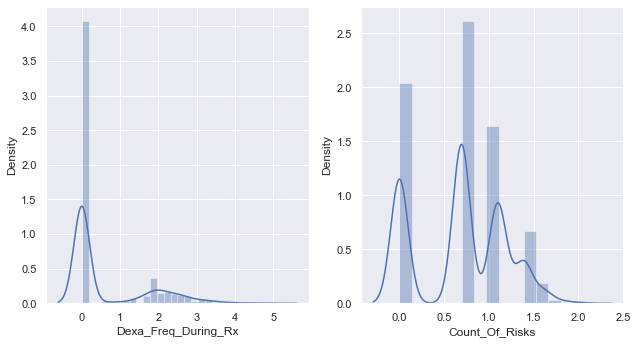

In [15]:
# Normal Distribution Check

# Dexa_Freq_During_Rx
plt.subplot(2,3,1)
sns.distplot(np.log1p(num_attributes['Dexa_Freq_During_Rx']));

# Count_Of_Risks
plt.subplot(2,3,2)
sns.distplot(np.log1p(num_attributes['Count_Of_Risks']));

## 1.5.2 Categorical Atributes

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(cat_attributes.apply(lambda x: x.unique().shape[0]))

Ptid                                                                  3424
Persistency_Flag                                                         2
Gender                                                                   2
Race                                                                     4
Ethnicity                                                                3
Region                                                                   5
Age_Bucket                                                               4
Ntm_Speciality                                                          36
Ntm_Specialist_Flag                                                      2
Ntm_Speciality_Bucket                                                    3
Gluco_Record_Prior_Ntm                                                   2
Gluco_Record_During_Rx                                                   2
Dexa_During_Rx                                                           2
Frag_Frac_Prior_Ntm      

# 2.0. STEP 02 - FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

## 2.1. Mind Map Hyphotesis

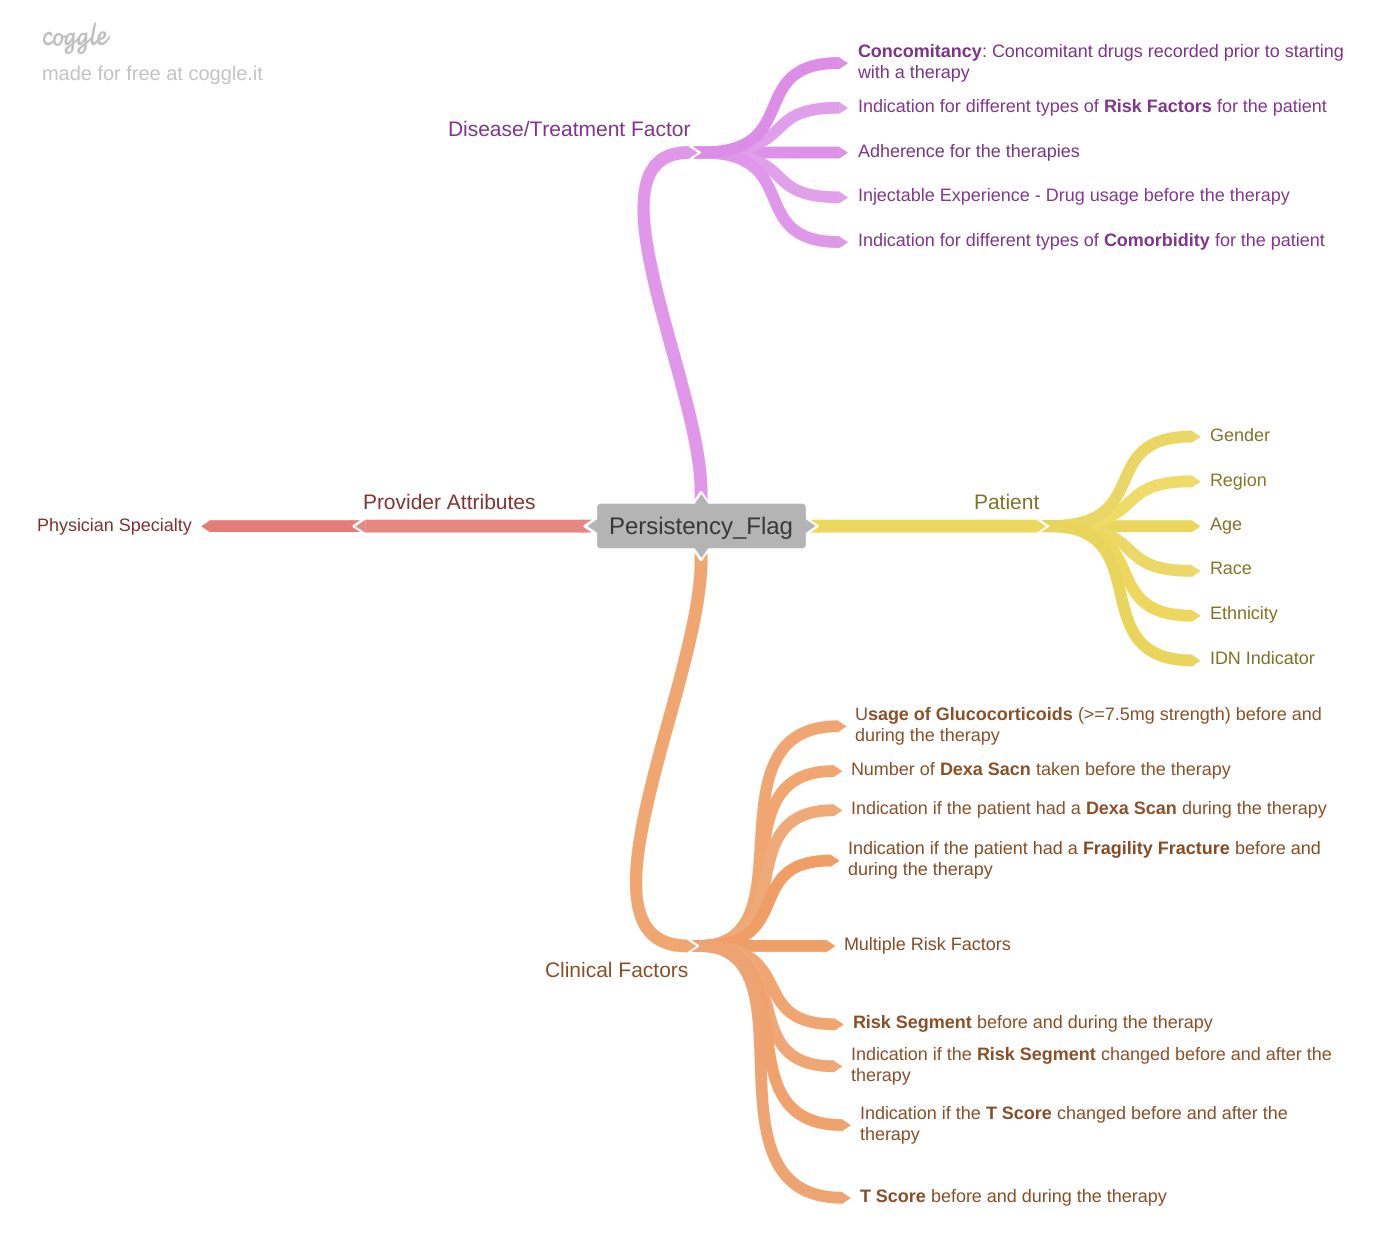

In [18]:
Image('Persistency_Flag.png')

## 2.2. Hyphotesis Creation

### 2.1.1 Patient Hypothesis

**1.** Female patients are more persistent of a drug than male.

**2.** Patients from Northeast are more persistent of a drug than patients from South.

**3.** Patients over 65 years of age are more persistent of a drug than patients 65 years of age or younger.

**4.** Caucasian patients, not hispanic are more persistent of a drug than patients with different race and ethinicity.

**5.** Patients mapped to IDN are more persistent of a drug than patient not mapped.

### 2.1.2 Povider Attributes Hypothesis

**1.** Patients that received the drug prescription from General Practtitioner Specialty are less persistent of a drug than patients that received the drug prescription from others Specialty.

### 2.1.3 Clinical Factors Hypothesis

**1.** Patients that used Glucocorticoid and had a Fragility Fracture, before and during the therapy, are more persistent of a drug than patients that not used Glucocorticoid neither had a Fragility Fracture, in any situation.

**2.** Patients that had Dexa Scan more than 0 times are more persistent of a drug than patients that had Dexa Scan less than 0 times.

**3.** Patients that presents VLR_LR as Risk Segment during the therapy and presents Unknown value in Risk Segment after the therapy are more persistent of a drug than patients that presents other types of Risk Segment and Change in Risk Segment.

**4.** Patients that presents T Socre of >-2.5 before the therapy and presents  No Change T Score status after the therapy are less persistent of a drug than patients that presents other types of T Score and T Score status.

### 2.1.4 Disease/Treatment Factor Hypothesis

**1.** Patients that presents the amount of risk factor higher than 1 are more persistent of a drug than patients that presents the amount of risk factor lower than 1.

**2.** Patients adherent for therapies and that used drugs berofe the therapy are more persistent of a drug than patients in different sutiations related to both attributes.

**3.** Patients that used more than 2 concomitancy drugs before the therapy are less persistent of a drug than patients that  used more than 2 concomitancy drugsbefore the therapy.

**4.** Patients that presents more than 3 diffetrent types of comorbidity are more persistent of a drug than patients that  presents less than 3 diffetrent types of comorbidity.

## 2.3. Hyphotesis Final List

**1.** Female patients are more persistent of a drug than male.

**2.** Patients from Northeast are more persistent of a drug than patients from South.

**3.** Patients over 65 years of age are more persistent of a drug than patients 65 years of age or younger.

**4.** Caucasian patients, not hispanic are more persistent of a drug than patients with different race and ethinicity.

**5.** Patients mapped to IDN are more persistent of a drug than patient not mapped.

**6.** Patients that received the drug prescription from General Practtitioner Specialty are less persistent of a drug than patients that received the drug prescription from others Specialty.

**7.** Patients that used Glucocorticoid and had a Fragility Fracture, before and during the therapy, are more persistent of a drug than patients that not used Glucocorticoid neither had a Fragility Fracture, in any situation.

**8.** Patients that had Dexa Scan more than 0 times are more persistent of a drug than patients that had Dexa Scan less than 0 times.

**9.** Patients that presents VLR_LR as Risk Segment during the therapy and presents Unknown value in Risk Segment after the therapy are more persistent of a drug than patients that presents other types of Risk Segment and Change in Risk Segment.

**10.** Patients that presents T Socre of >-2.5 before the therapy and presents  No Change T Score status after the therapy are less persistent of a drug than patients that presents other types of T Score and T Score status.

**11.** Patients that presents the amount of risk factor higher than 1 are more persistent of a drug than patients that presents the amount of risk factor lower than 1.

**12.** Patients adherent for therapies and that used drugs berofe the therapy are more persistent of a drug than patients in different sutiations related to both attributes.

**13.** Patients that used more than 2 concomitancy drugs before the therapy are less persistent of a drug than patients that  used more than 2 concomitancy drugsbefore the therapy.

**14.** Patients that presents more than 3 diffetrent types of comorbidity are more persistent of a drug than patients that  presents less than 3 diffetrent types of comorbidity.

## 2.4. Feature Engineering

In [19]:
# Replacing all values 'Y' (Yes) and 'N' (No) for 1 (Yes) and 0 (No), of all categorical attributes Concomitancy and Comorbidity
data = df2.iloc[:, 25:49].replace('Y', 1).replace('N', 0)

# Count_Of_Concomitancy
df2['Count_Of_Concomitancy'] = data.iloc[:, 14:24].dot(np.ones(data.iloc[:, 14:24].shape[1]))
df2['Count_Of_Concomitancy'] = df2['Count_Of_Concomitancy'].astype(np.int64)

# Count_Of_Comorbidity
df2['Count_Of_Comorbidity'] = data.iloc[:, 0:14].dot(np.ones(data.iloc[:, 0:14].shape[1]))
df2['Count_Of_Comorbidity'] = df2['Count_Of_Comorbidity'].astype(np.int64)   

df2

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,Count_Of_Concomitancy,Count_Of_Comorbidity
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0,0,5
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0,0,1
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2,1,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1,3,6
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,P3420,Persistent,Female,Caucasian,Not Hispanic,South,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,Y,Y,Y,N,Y,Y,N,N,N,Y,N,Y,Y,N,N,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,1,

In [20]:
df2.dtypes

Ptid                     object
Persistency_Flag         object
Gender                   object
Race                     object
Ethnicity                object
                          ...  
Risk_Immobilization      object
Risk_Recurring_Falls     object
Count_Of_Risks            int64
Count_Of_Concomitancy     int64
Count_Of_Comorbidity      int64
Length: 71, dtype: object

# 3.0. STEP 03 - VARIABLES FILTER

In [21]:
df3 = df2.copy()

In [22]:
df3.head()

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,Count_Of_Concomitancy,Count_Of_Comorbidity
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0,0,5
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0,0,1
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2,1,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1,3,6
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1,3,5


## 3.1. Columns Selection

In [23]:
df3[(df3['Dexa_Freq_During_Rx'] == 0) & (df3['Dexa_During_Rx'] == 'Y')].shape

(0, 71)

Because there are no values 'Y' in column 'Dexa_During_Rx' for values 0 in column 'Dexa_Freq_During_Rx', it is assumed 
that all values 0 in column 'Dexa_Freq_During_Rx' are values 'N' in column 'Dexa_During_Rx', and all values above
0 in column 'Dexa_Freq_During_Rx' are 'Y' values in column 'Dexa_During_Rx'. So there is no need to use the 
Dexa_During_Rx' column, so it can be excluded from the dataset.

In [24]:
### Business Restriction for columns:
cols_drop = ['Dexa_During_Rx'] 
df3 = df3.drop(cols_drop, axis=1)

In [25]:
print('Number of Rows: {}'.format(df3.shape[0]))
print('Number of Columns: {}'.format(df3.shape[1]))

Number of Rows: 3424
Number of Columns: 70


# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS (EDA)

In [26]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

<AxesSubplot:xlabel='Persistency_Flag', ylabel='count'>

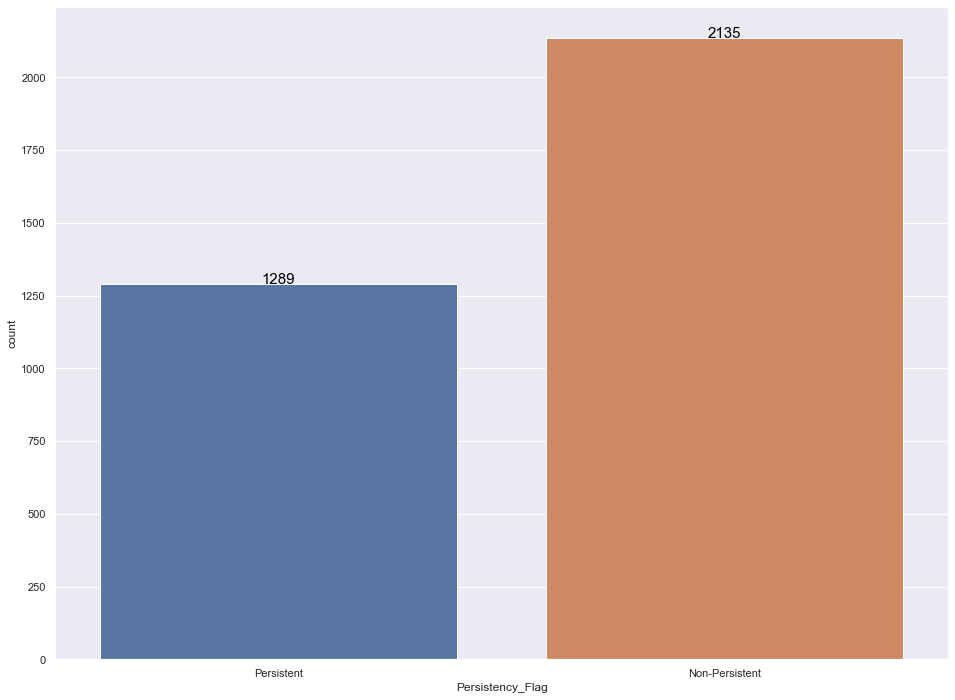

In [49]:
plot = sns.countplot(x="Persistency_Flag",data=df1, dodge=True)
bar_value(plot)

### 4.1.2. Numerical Variable

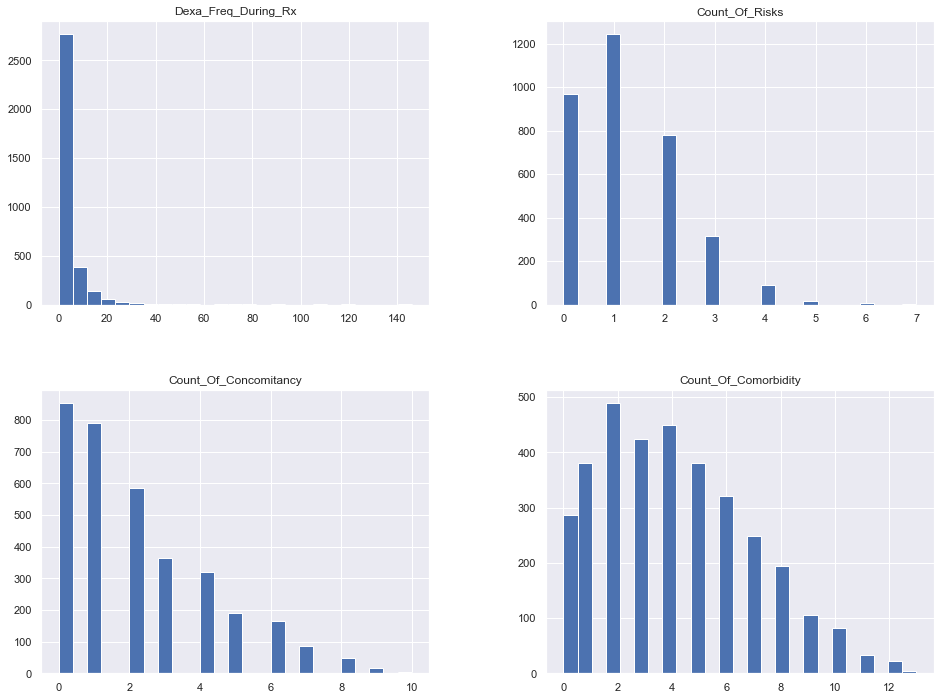

In [28]:
a = df4.select_dtypes(include=['int64', 'float64'])

a.hist(bins = 25);

All numerical attributes show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

All variables show a positive skew, trending to the left. And the variable 'Dexa_Freq_During_Rx' presents a very high kurtosis, because its values are extremely concentrated on the value 0.

### 4.1.3. Categorical Variable

The Categorical Variable will be analyzed in Bivariate Analysis, in the hypothesis tests.

## 4.2. Bivariate Analysis

### H1.** Female patients are more persistent of a drug than male.
**TRUE** There are 1212 female persistent patients and 77 male persistent patients, which means, there are a difference between the genders of 1135 persistent patients.

<AxesSubplot:xlabel='Gender', ylabel='Ptid'>

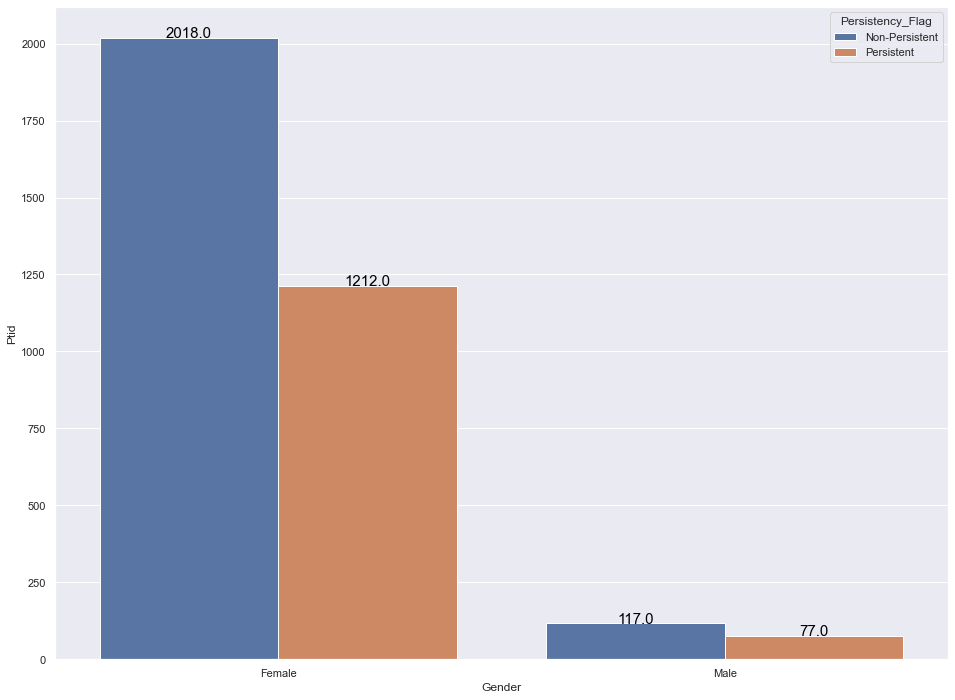

In [50]:
H1 = df4[['Ptid', 'Gender', 'Persistency_Flag']].groupby(['Gender', 'Persistency_Flag']).count().reset_index()

plot = sns.barplot(x = 'Gender', y = 'Ptid', hue = 'Persistency_Flag', data = H1);
bar_value(plot)

The categorical attribute 'Gender' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### H2.** Patients from Northeast are more persistent of a drug than patients from South.
**FALSE** There are 98 persistent patients from Northeast and 494 persistent patients from South, which means, there are a difference between the regions of 396 persistent patients.

<AxesSubplot:xlabel='Region', ylabel='Ptid'>

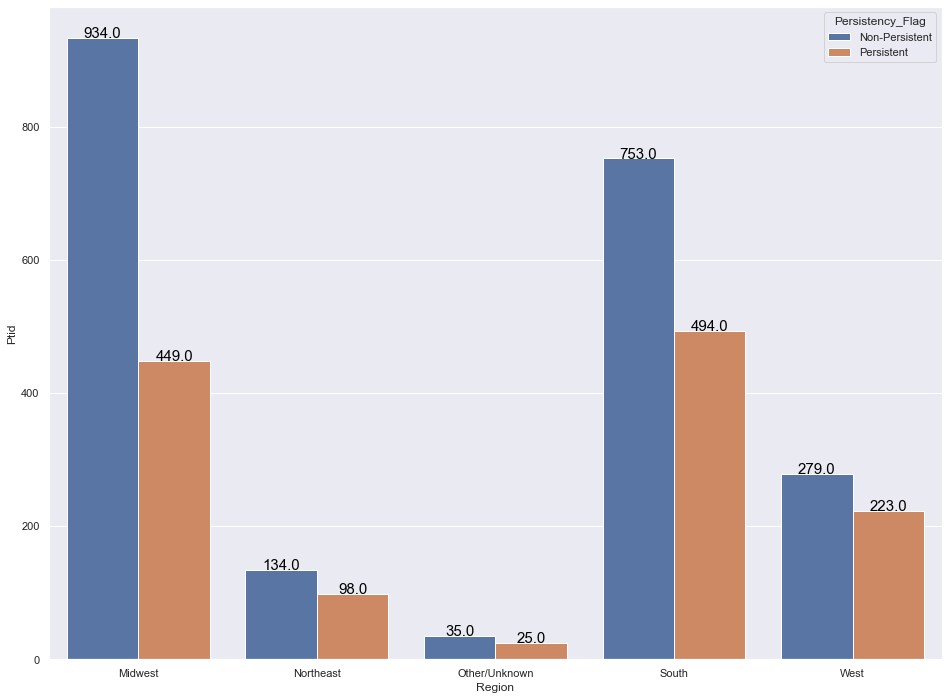

In [51]:
H2 = df4[['Ptid', 'Region', 'Persistency_Flag']].groupby(['Region', 'Persistency_Flag']).count().reset_index()

plot = sns.barplot(x = 'Region', y = 'Ptid', hue = 'Persistency_Flag', data = H2);
bar_value(plot)

The categorical attribute 'Region' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### H3.** Patients over 65 years of age are more persistent of a drug than patients 65 years of age or younger.
**TRUE** There are 965 persistent patients over 65 of age and 324 persistent patients' young than 65 years of age, which means, there are a difference between the ages of 641 persistent patients.

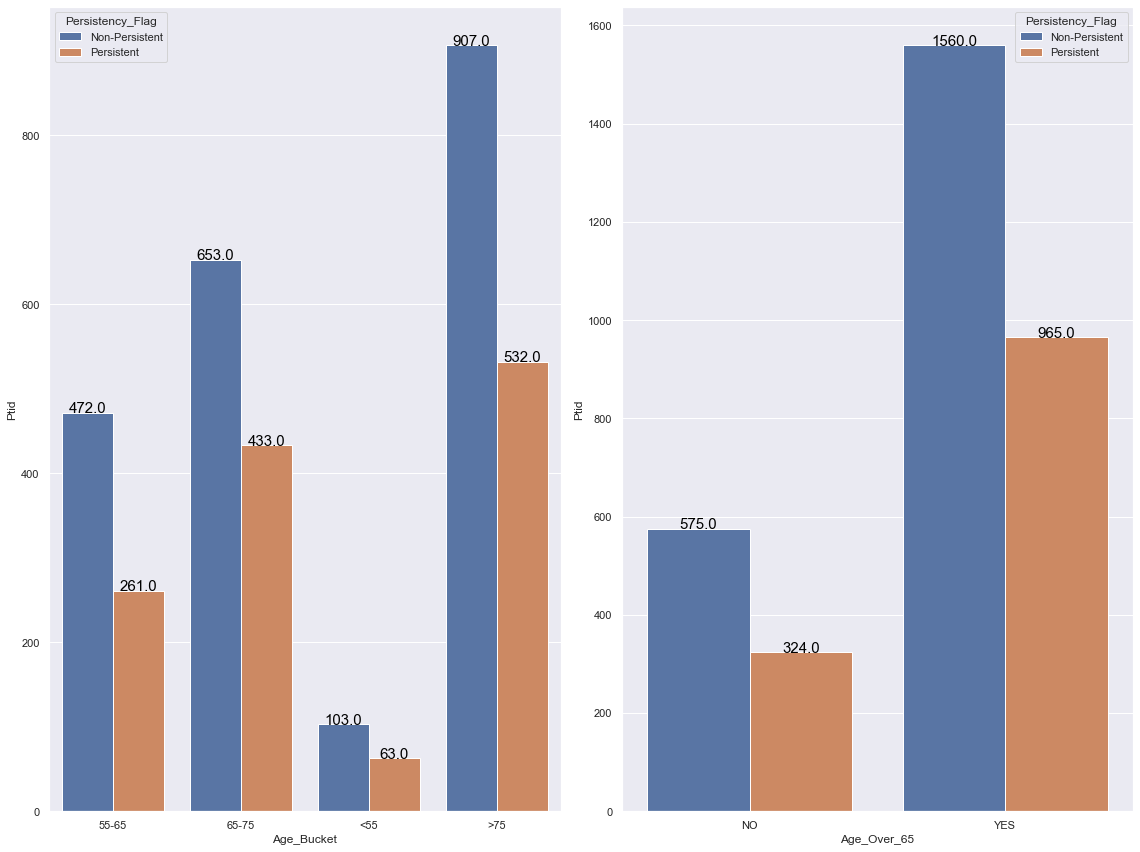

In [52]:
H3 = df4[['Ptid', 'Age_Bucket', 'Persistency_Flag']].groupby(['Age_Bucket', 'Persistency_Flag']).count().reset_index()

aux_H3 = df4[['Ptid', 'Age_Bucket', 'Persistency_Flag']]      
aux_H3['Age_Over_65'] = aux_H3.apply(lambda x: 'NO' if (x['Age_Bucket'] == '<55') | (x['Age_Bucket'] =='55-65') else
                                           'YES' , axis = 1)
        
H3_1 = aux_H3[['Ptid', 'Age_Over_65', 'Persistency_Flag']].groupby(['Age_Over_65', 'Persistency_Flag']).count().reset_index()

plt.subplot(1,2,1)
plot1 = sns.barplot(x = 'Age_Bucket', y = 'Ptid', hue = 'Persistency_Flag', data = H3);
bar_value(plot1)
plt.tight_layout()

plt.subplot(1,2,2)
plot2 = sns.barplot(x = 'Age_Over_65', y = 'Ptid', hue = 'Persistency_Flag', data = H3_1);
bar_value(plot2)
plt.tight_layout()

The categorical attribute 'Age_Bucket' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### **H4**. Caucasian patients, not Hispanic are more persistent of a drug than patients with different race and ethinicity.
**TRUE** There are 1141 Caucasian Not Hispanic persistent patients and 148 persistent patients from different race and ethnicity, which means, there are a difference between race and ethnicity of 993 persistent patients.

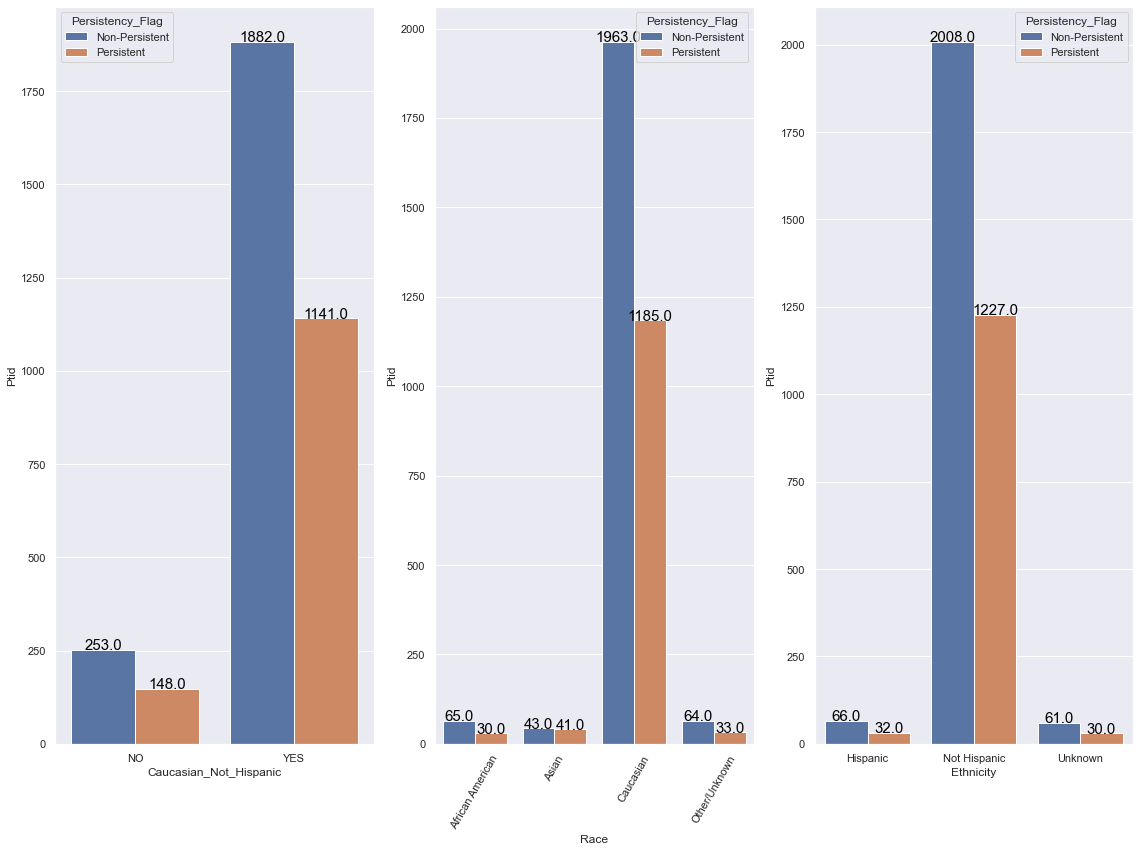

In [53]:
H4 = df4[['Ptid', 'Race', 'Ethnicity', 'Persistency_Flag']].groupby(['Race', 'Ethnicity', 'Persistency_Flag']).count().reset_index()


aux_H4 = df4[['Ptid', 'Race', 'Ethnicity', 'Persistency_Flag']]       
aux_H4['Caucasian_Not_Hispanic'] = aux_H4.apply(lambda x: 'YES' if (x['Race'] == 'Caucasian') & (x['Ethnicity'] == 'Not Hispanic') else
                                           'NO' , axis = 1)

H4_1 = aux_H4[['Ptid', 'Caucasian_Not_Hispanic', 'Persistency_Flag']].groupby(['Caucasian_Not_Hispanic', 'Persistency_Flag']).count().reset_index()


plt.subplot(1,3,1)
plot1 = sns.barplot(x = 'Caucasian_Not_Hispanic', y = 'Ptid', hue = 'Persistency_Flag', data = H4_1);
bar_value(plot1)
plt.tight_layout()

plt.subplot(1,3,2)
H4_2 = df4[['Ptid', 'Race', 'Persistency_Flag']].groupby(['Race', 'Persistency_Flag']).count().reset_index()
plot2 = sns.barplot(x = 'Race', y = 'Ptid', hue = 'Persistency_Flag', data = H4_2);
bar_value(plot2)
plt.xticks(rotation=60);
plt.tight_layout()

plt.subplot(1,3,3)
H4_3 = df4[['Ptid', 'Ethnicity', 'Persistency_Flag']].groupby(['Ethnicity', 'Persistency_Flag']).count().reset_index()
plot3 = sns.barplot(x = 'Ethnicity', y = 'Ptid', hue = 'Persistency_Flag', data = H4_3);
bar_value(plot3)
plt.tight_layout()

The categorical attribute 'Race', despite the huge difference between Caucasian to others, does not show a well varied behavior,  not presenting a huge relevance information for the learning of the ML model. 

The categorical attribute 'Ethnicity', dispate the huge differenve between Not Hispanic to others, does not show a well varied behavior,  not presenting a huge relevance information for the learning of the ML model. 

### **H5.** Patients mapped to IDN are more persistent of a drug than patient not mapped.
**TRUE** There are 1043 persistent patients mapped to IDN and 246 persistent patients not mapped to IDN, which means, there are a difference between persistent patients mapped to IDN of 797 patients.

<AxesSubplot:xlabel='Idn_Indicator', ylabel='Ptid'>

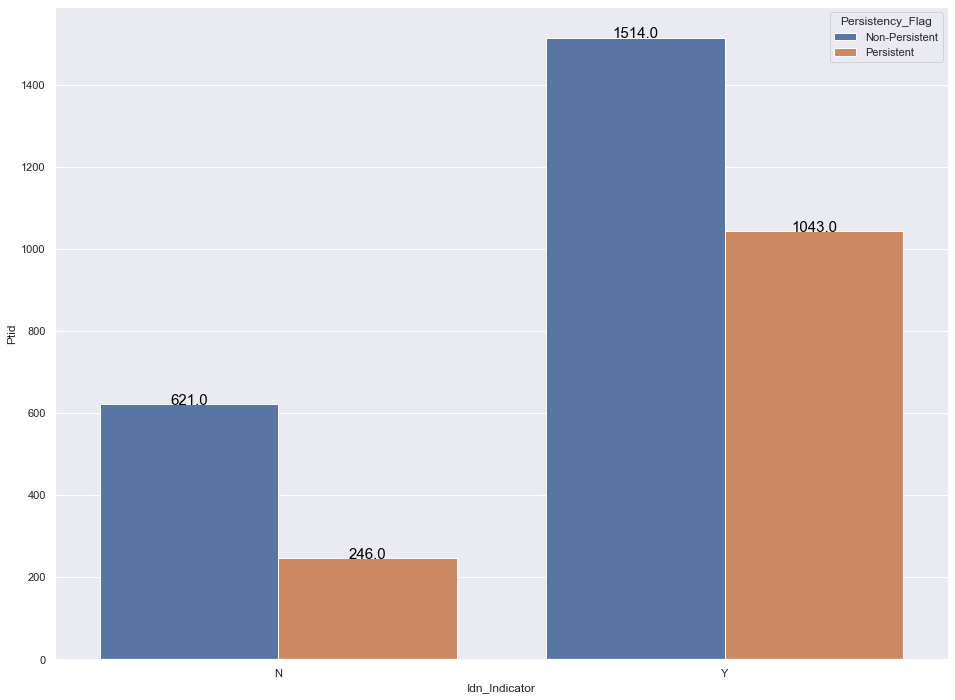

In [54]:
H5 = df4[['Ptid', 'Idn_Indicator', 'Persistency_Flag']].groupby(['Idn_Indicator', 'Persistency_Flag']).count().reset_index()

plot = sns.barplot(x = 'Idn_Indicator', y = 'Ptid', hue = 'Persistency_Flag', data = H5);
bar_value(plot)

The categorical attribute 'Idn_Indicator' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### H6.** Patients that received the drug prescription from General Practitioner Specialty are less persistent of a drug than patients that received the drug prescription from others Specialty.
**FALSE** There are 494 persistent patients that received the drug prescription from General Practitioner Specialty and 795 persistent patients that received the drug prescription from others Specialty, there are a difference of 301 persistent patients.

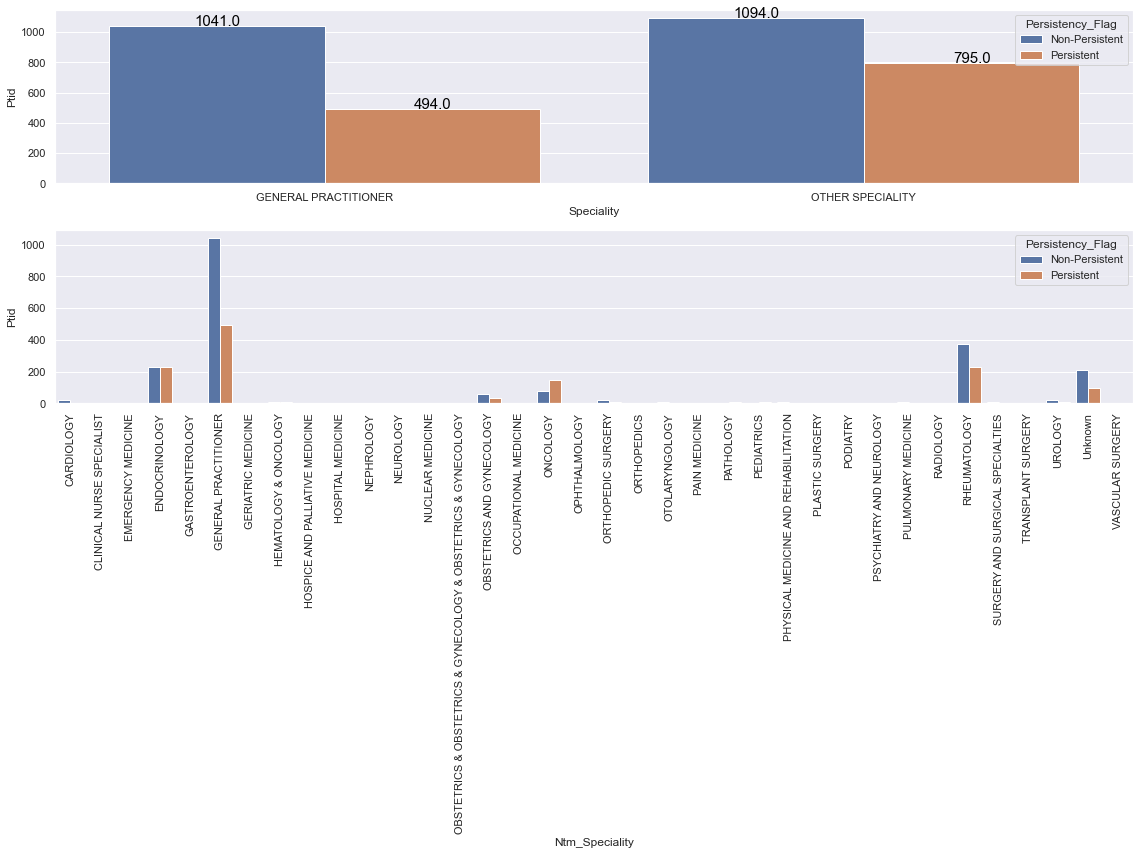

In [55]:
H6 = df4[['Ptid', 'Ntm_Speciality', 'Persistency_Flag']].groupby(['Ntm_Speciality', 'Persistency_Flag']).count().reset_index()

aux_H6 = df4[['Ptid', 'Ntm_Speciality', 'Persistency_Flag']]      
aux_H6['Speciality'] = aux_H6.apply(lambda x: 'OTHER SPECIALITY' if (x['Ntm_Speciality'] != 'GENERAL PRACTITIONER') else
                                              'GENERAL PRACTITIONER' , axis = 1)
    
H6_1 = aux_H6[['Ptid', 'Speciality', 'Persistency_Flag']].groupby(['Speciality', 'Persistency_Flag']).count().reset_index()


plt.subplot(2,1,1)
plot1 = sns.barplot(x = 'Speciality', y = 'Ptid', hue = 'Persistency_Flag', data = H6_1);
bar_value(plot1)
plt.tight_layout()

plt.subplot(2,1,2)
sns.barplot(x = 'Ntm_Speciality', y = 'Ptid', hue = 'Persistency_Flag', data = H6);

plt.xticks(rotation=90);
plt.tight_layout()

The categorical attribute 'Ntm_Speciality' does not present a well varied behavior among all speciality except for the general prectioner. Due this fact the variavle do not present a huge relevance information for the learning of the ML model.

### **H7.** Patients that used Glucocorticoid and had a Fragility Fracture, before and during the therapy, are more persistent of a drug than patients that not used Glucocorticoid either had a Fragility Fracture, in any situation.
**FALSE** There are 24 persistent patients that used Glucocorticoid and had a Fragility Fracture, before and during the therapy and 555 persistent patients that did not use Glucocorticoid neither had a Fragility Fracture, in any situation, which means, there are a difference between both status of 531 persistent patients.

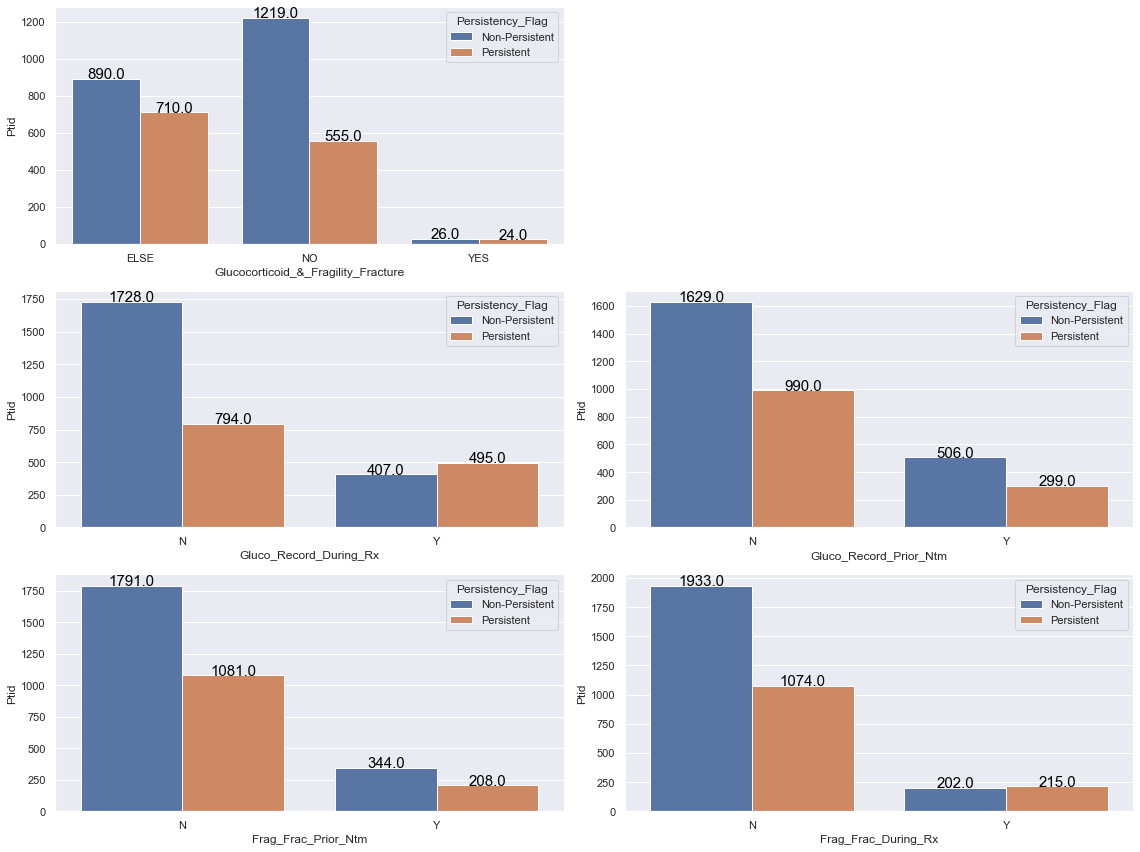

In [56]:
aux_H7 = df4[['Ptid', 'Gluco_Record_During_Rx', 'Gluco_Record_Prior_Ntm', 'Persistency_Flag', 'Frag_Frac_Prior_Ntm', 'Frag_Frac_During_Rx']]

aux_H7['Glucocorticoid_&_Fragility_Fracture'] = aux_H7.apply(lambda x: 'YES' if (x['Gluco_Record_During_Rx'] == 'Y') & 
                                                                                (x['Gluco_Record_Prior_Ntm'] == 'Y') & 
                                                                                (x['Frag_Frac_Prior_Ntm'] == 'Y') & 
                                                                                (x['Frag_Frac_During_Rx'] == 'Y')      else
                                                                        'NO' if (x['Gluco_Record_During_Rx'] == 'N') & 
                                                                                (x['Gluco_Record_Prior_Ntm'] == 'N') & 
                                                                                (x['Frag_Frac_Prior_Ntm'] == 'N') & 
                                                                                (x['Frag_Frac_During_Rx'] == 'N')      else
                                                                        'ELSE', axis = 1)

H7 = aux_H7[['Ptid', 'Glucocorticoid_&_Fragility_Fracture', 'Persistency_Flag']].groupby(['Glucocorticoid_&_Fragility_Fracture', 'Persistency_Flag']).count().reset_index()

plt.subplot(3,2,1)
plot1 = sns.barplot(x = 'Glucocorticoid_&_Fragility_Fracture', y = 'Ptid', hue = 'Persistency_Flag', data = H7);
bar_value(plot1)
plt.tight_layout()

plt.subplot(3,2,3)
H7_2 = df4[['Ptid', 'Gluco_Record_During_Rx', 'Persistency_Flag']].groupby(['Gluco_Record_During_Rx', 'Persistency_Flag']).count().reset_index()
plot2 = sns.barplot(x = 'Gluco_Record_During_Rx', y = 'Ptid', hue = 'Persistency_Flag', data = H7_2);
bar_value(plot2)
plt.tight_layout()

plt.subplot(3,2,4)
H7_3 = df4[['Ptid', 'Gluco_Record_Prior_Ntm', 'Persistency_Flag']].groupby(['Gluco_Record_Prior_Ntm', 'Persistency_Flag']).count().reset_index()
plot3 = sns.barplot(x = 'Gluco_Record_Prior_Ntm', y = 'Ptid', hue = 'Persistency_Flag', data = H7_3);
bar_value(plot3)
plt.tight_layout()

plt.subplot(3,2,5)
H7_4 = df4[['Ptid', 'Frag_Frac_Prior_Ntm', 'Persistency_Flag']].groupby(['Frag_Frac_Prior_Ntm', 'Persistency_Flag']).count().reset_index()
plot4 = sns.barplot(x = 'Frag_Frac_Prior_Ntm', y = 'Ptid', hue = 'Persistency_Flag', data = H7_4);
bar_value(plot4)
plt.tight_layout()

plt.subplot(3,2,6)
H7_5 = df4[['Ptid', 'Frag_Frac_During_Rx', 'Persistency_Flag']].groupby(['Frag_Frac_During_Rx', 'Persistency_Flag']).count().reset_index()
plot5 = sns.barplot(x = 'Frag_Frac_During_Rx', y = 'Ptid', hue = 'Persistency_Flag', data = H7_5);
bar_value(plot5)
plt.tight_layout()

All categorical attributes in this hyphotesis show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### **H8.** Patients that had Dexa Scan more than 0 times are more persistent of a drug than patients that had Dexa Scan 0 times.
**FALSE** There are 716 persistent patients that had Dexa Scan more than 0 times and 573 persistent patients that had Dexa Scan 0 times, which means, there are a difference between both status of 185 persistent patients.

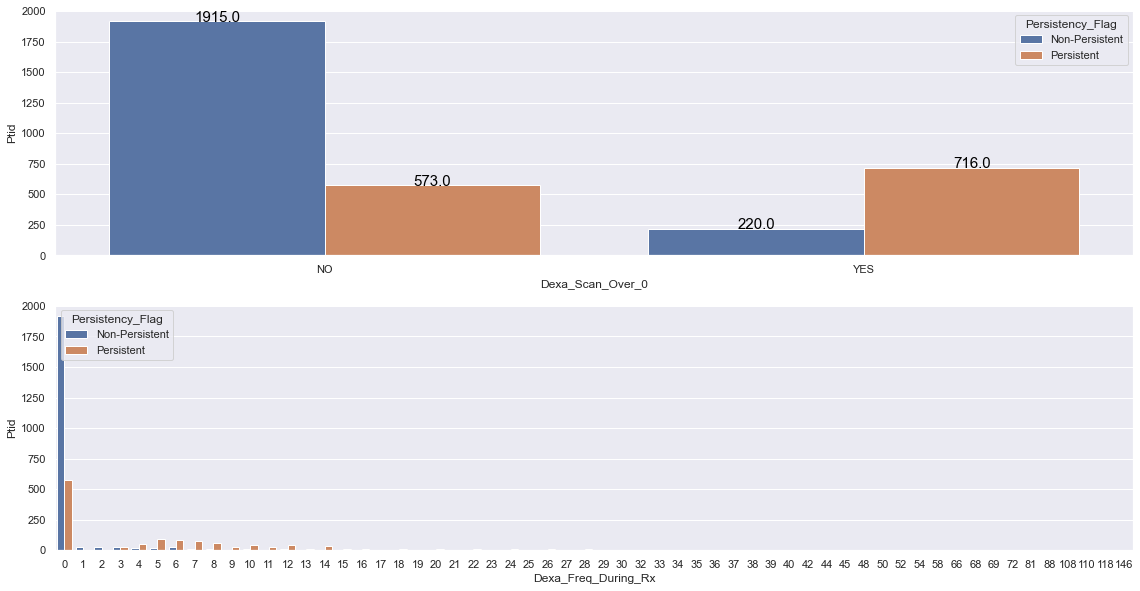

In [57]:
H8 = df4[['Ptid', 'Dexa_Freq_During_Rx', 'Persistency_Flag']].groupby(['Dexa_Freq_During_Rx', 'Persistency_Flag']).count().reset_index()

aux_H8 = df4[['Ptid', 'Dexa_Freq_During_Rx', 'Persistency_Flag']]      
aux_H8['Dexa_Scan_Over_0'] = aux_H8.apply(lambda x: 'YES' if (x['Dexa_Freq_During_Rx'] > 0) else
                                                    'NO' , axis = 1)
       
H8_1 = aux_H8[['Ptid', 'Dexa_Scan_Over_0', 'Persistency_Flag']].groupby(['Dexa_Scan_Over_0', 'Persistency_Flag']).count().reset_index()

plt.subplot(3,1,1)
plot1 = sns.barplot(x = 'Dexa_Scan_Over_0', y = 'Ptid', hue = 'Persistency_Flag', data = H8_1);
bar_value(plot1)
plt.tight_layout()

plt.subplot(3,1,2)
sns.barplot(x = 'Dexa_Freq_During_Rx', y = 'Ptid', hue = 'Persistency_Flag', data = H8);
plt.tight_layout()

The categorical attribute 'Dexa_Freq_During_Rx' does not present a well varied behavior among all times that the scan happened, except for o times. Due this fact the variavle do not present a huge relevance information for the learning of the ML model.

### **H9.** Patients that presents VLR_LR as Risk Segment during the therapy and presents Unknown value in Risk Segment after the therapy are more persistent of a drug than patients that present other types of Risk Segment and Change in Risk Segment.
**FALSE** There are 324 persistent patients that presents VLR_LR as Risk Segment during the therapy and presents Unknown value in Risk Segment after the therapy and 965 persistent patients that presents other types of Risk Segment and Change on Risk Segment, which means, there are a difference between both status of 641 persistent patients.

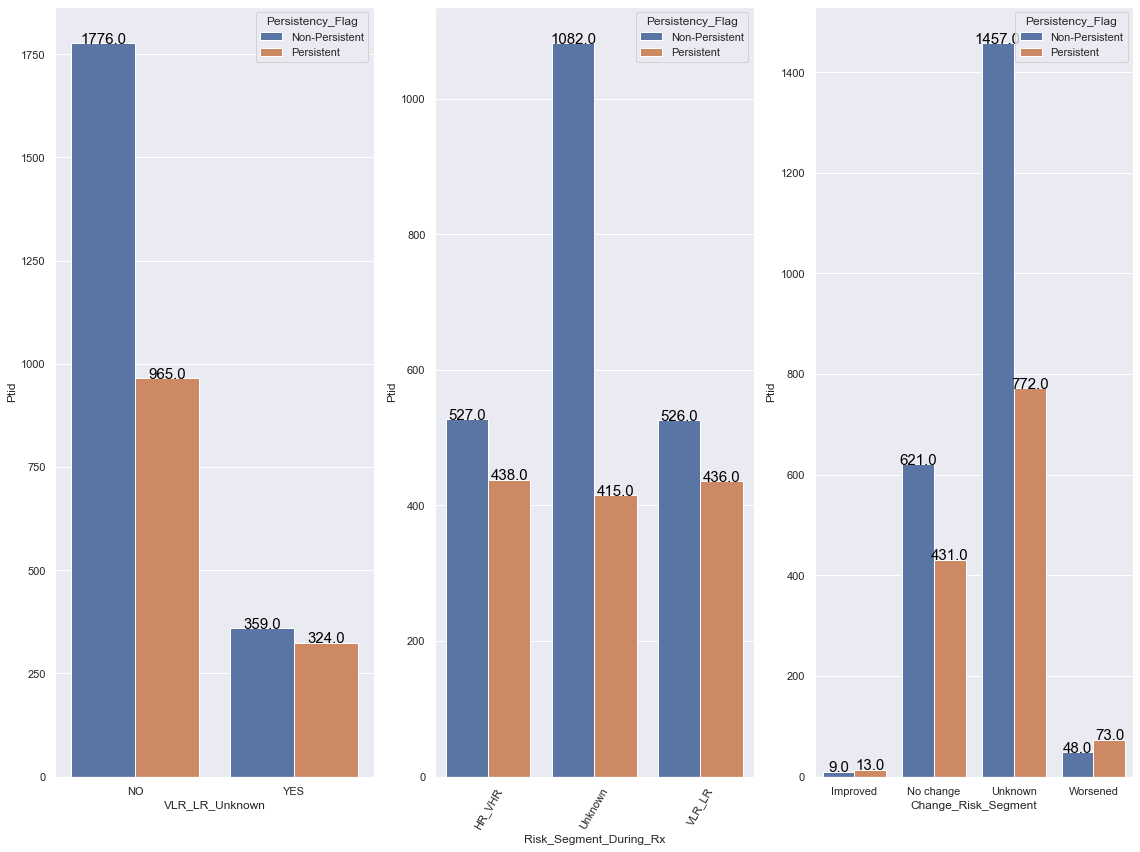

In [58]:
H9 = df4[['Ptid', 'Risk_Segment_During_Rx', 'Change_Risk_Segment', 'Persistency_Flag']].groupby(['Risk_Segment_During_Rx', 'Change_Risk_Segment', 'Persistency_Flag']).count().reset_index()

aux_H9 = df4[['Ptid', 'Risk_Segment_During_Rx', 'Change_Risk_Segment', 'Persistency_Flag',]]      
aux_H9['VLR_LR_Unknown'] = aux_H9.apply(lambda x: 'YES' if (x['Risk_Segment_During_Rx'] == 'VLR_LR') & 
                                                            (x['Change_Risk_Segment'] == 'Unknown') else
                                                    'NO' , axis = 1)

H9_1 = aux_H9[['Ptid', 'VLR_LR_Unknown', 'Persistency_Flag']].groupby(['VLR_LR_Unknown', 'Persistency_Flag']).count().reset_index()

plt.subplot(1,3,1)
plot1 = sns.barplot(x = 'VLR_LR_Unknown', y = 'Ptid', hue = 'Persistency_Flag', data = H9_1);
bar_value(plot1)
plt.tight_layout()

plt.subplot(1,3,2)
H9_2 = df4[['Ptid', 'Risk_Segment_During_Rx', 'Persistency_Flag']].groupby(['Risk_Segment_During_Rx', 'Persistency_Flag']).count().reset_index()
plot2 = sns.barplot(x = 'Risk_Segment_During_Rx', y = 'Ptid', hue = 'Persistency_Flag', data = H9_2);
bar_value(plot2)
plt.xticks(rotation=60);
plt.tight_layout()

plt.subplot(1,3,3)
H9_3 = df4[['Ptid', 'Change_Risk_Segment', 'Persistency_Flag']].groupby(['Change_Risk_Segment', 'Persistency_Flag']).count().reset_index()
plot3 = sns.barplot(x = 'Change_Risk_Segment', y = 'Ptid', hue = 'Persistency_Flag', data = H9_3);
bar_value(plot3)
plt.tight_layout()

The categorical attribute 'Risk_Segment_During_Rx', despite the huge difference between the value Unknown - Non-Persistent to others, dthis attribute does not show a well varied behavior, not presenting a huge relevance information for the learning of the ML model. 

The categorical attribute 'Change_Risk_Segment' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### **H10.** Patients that presents T Socre of >-2.5 before the therapy and presents  No Change T Score status after the therapy are less persistent of a drug than patients that presents other types of T Score and T Score status.
**TRUE** There are 413 persistent patients that presents T Score of >-2.5 before the therapy and presents  No Change T Score status after the therapy and 876 persistent patients that presents other types of T Score and Change on T Score, which means, there are a difference between both status of 463 persistent patients.

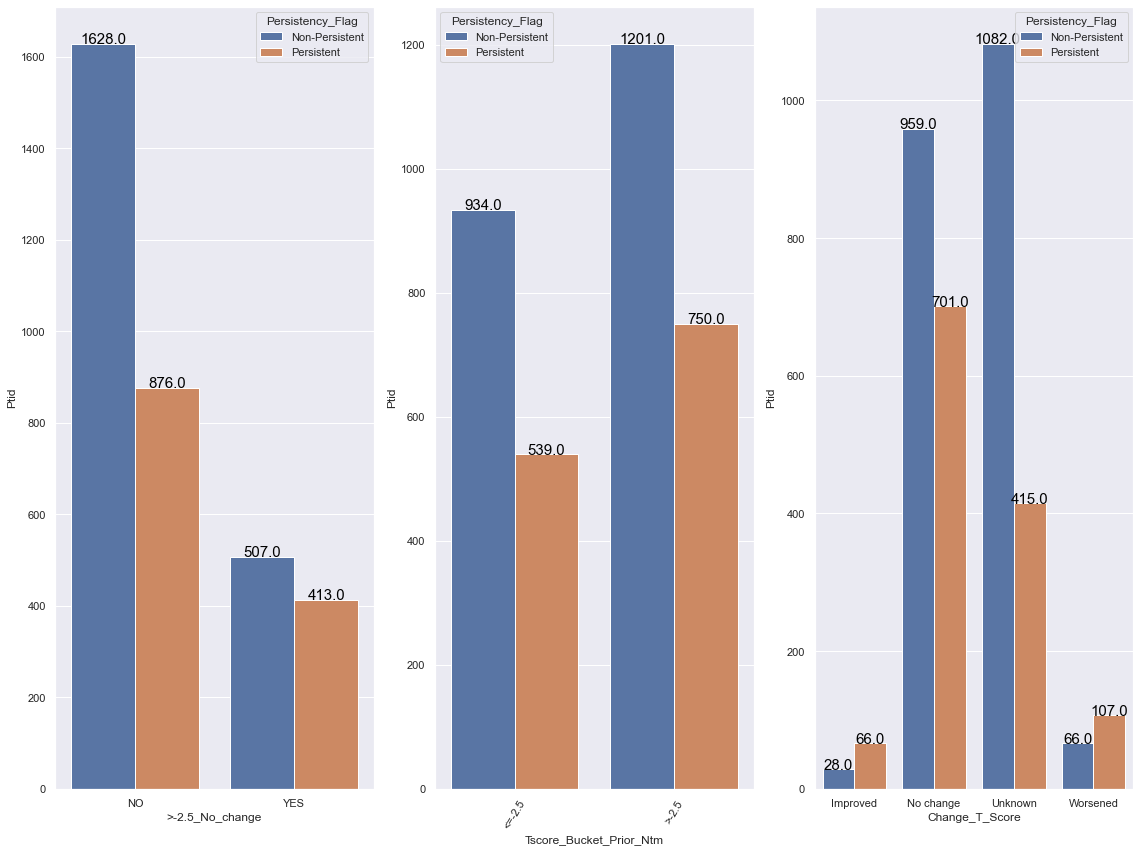

In [59]:
H10 = df4[['Ptid', 'Tscore_Bucket_Prior_Ntm', 'Change_T_Score', 'Persistency_Flag']].groupby(['Tscore_Bucket_Prior_Ntm', 'Change_T_Score', 'Persistency_Flag']).count().reset_index()

aux_H10 = df4[['Ptid', 'Tscore_Bucket_Prior_Ntm', 'Change_T_Score', 'Persistency_Flag',]]      
aux_H10['>-2.5_No_change'] = aux_H10.apply(lambda x: 'YES' if (x['Tscore_Bucket_Prior_Ntm'] == '>-2.5') & 
                                                             (x['Change_T_Score'] == 'No change') else
                                                    'NO' , axis = 1)

H10_1 = aux_H10[['Ptid', '>-2.5_No_change', 'Persistency_Flag']].groupby(['>-2.5_No_change', 'Persistency_Flag']).count().reset_index()

plt.subplot(1,3,1)
plot1 = sns.barplot(x = '>-2.5_No_change', y = 'Ptid', hue = 'Persistency_Flag', data = H10_1);
bar_value(plot1)
plt.tight_layout()

plt.subplot(1,3,2)
H10_2 = df4[['Ptid', 'Tscore_Bucket_Prior_Ntm', 'Persistency_Flag']].groupby(['Tscore_Bucket_Prior_Ntm', 'Persistency_Flag']).count().reset_index()
plot2 = sns.barplot(x = 'Tscore_Bucket_Prior_Ntm', y = 'Ptid', hue = 'Persistency_Flag', data = H10_2);
bar_value(plot2)
plt.xticks(rotation=60);
plt.tight_layout()

plt.subplot(1,3,3)
H10_3 = df4[['Ptid', 'Change_T_Score', 'Persistency_Flag']].groupby(['Change_T_Score', 'Persistency_Flag']).count().reset_index()
plot3 = sns.barplot(x = 'Change_T_Score', y = 'Ptid', hue = 'Persistency_Flag', data = H10_3);
bar_value(plot3)
plt.tight_layout()

The categorical attribute 'Tscore_Bucket_Prior_Ntm' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

The categorical attribute 'Change_T_Score' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### **H11.** Patients that presents the amount of risk factor higher than 1 are more persistent of a drug than patients that presents the amount of risk factor lower than 1.
**FALSE** There are 783 persistent patients that do not presents the amount of risk factor higher than 1 and 506 persistent patients that presents the amount of risk factor higher than 1, which means, there are a difference between both status of 277 persistent patients.

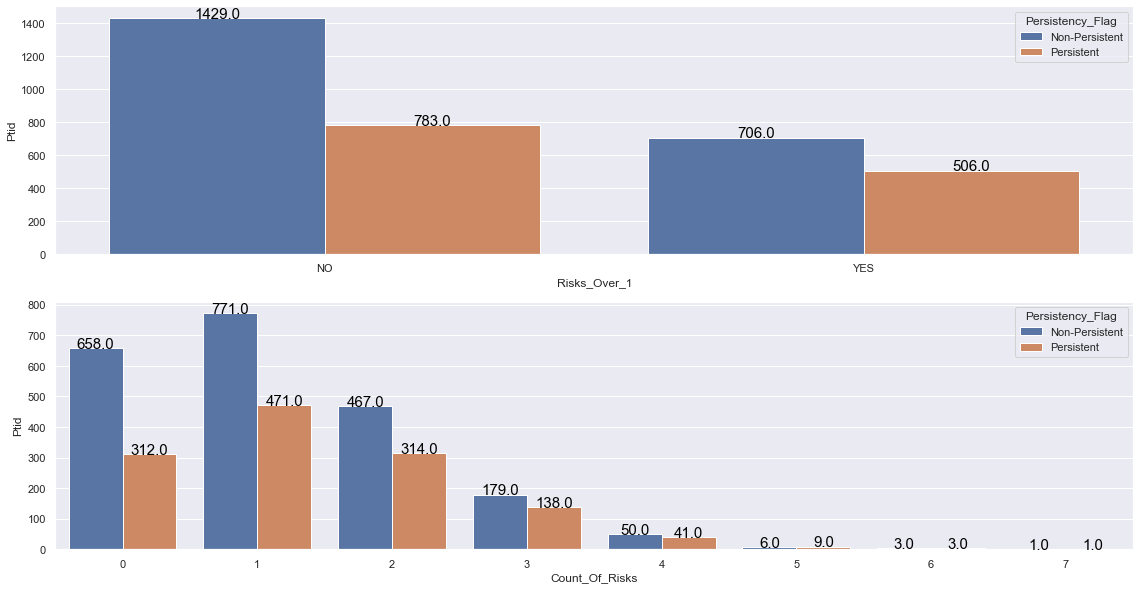

In [60]:
H11 = df4[['Ptid', 'Count_Of_Risks', 'Persistency_Flag']].groupby(['Count_Of_Risks', 'Persistency_Flag']).count().reset_index()

aux_H11 = df4[['Ptid', 'Count_Of_Risks', 'Persistency_Flag']]      
aux_H11['Risks_Over_1'] = aux_H11.apply(lambda x: 'YES' if (x['Count_Of_Risks'] > 1) else
                                                  'NO' , axis = 1)
      
H11_1 = aux_H11[['Ptid', 'Risks_Over_1', 'Persistency_Flag']].groupby(['Risks_Over_1', 'Persistency_Flag']).count().reset_index()

plt.subplot(3,1,1)
plot1 = sns.barplot(x = 'Risks_Over_1', y = 'Ptid', hue = 'Persistency_Flag', data = H11_1);
bar_value(plot1)
plt.tight_layout()

plt.subplot(3,1,2)
plot2 = sns.barplot(x = 'Count_Of_Risks', y = 'Ptid', hue = 'Persistency_Flag', data = H11);
bar_value(plot2)
plt.tight_layout()

The categorical attribute 'Count_Of_Risks' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### **H12.** Patients adherent for therapies and that used drugs during the therapy are more persistent of a drug than patients in different situations related to both attributes.
**TRUE** There are 1100 persistent patients adherent for therapies and that used drugs before the therapy and 506 persistent patients that are not  adherent for therapies and that did not use drugs before the therap, which means, there are differences between both status of 189 persistent patients.

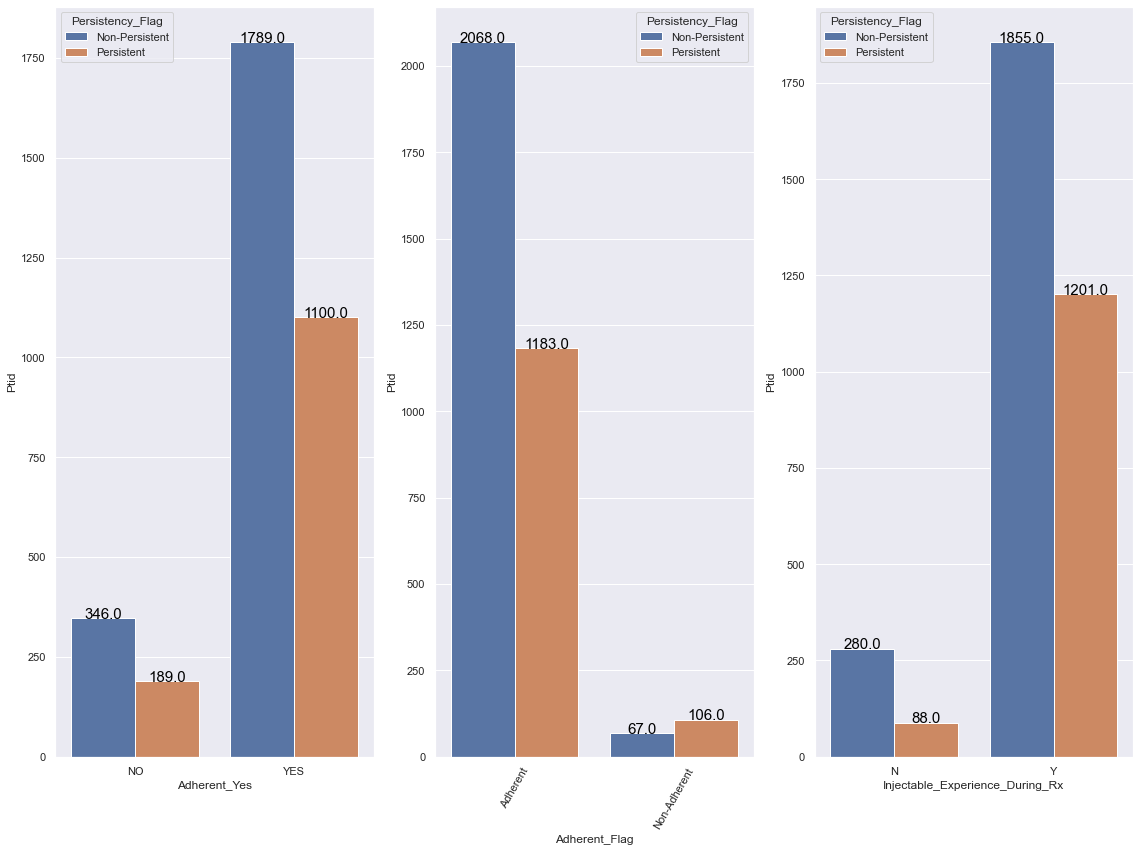

In [61]:
H12 = df4[['Ptid', 'Adherent_Flag', 'Injectable_Experience_During_Rx', 'Persistency_Flag']].groupby(['Adherent_Flag', 'Injectable_Experience_During_Rx', 'Persistency_Flag']).count().reset_index()

aux_H12 = df4[['Ptid', 'Adherent_Flag', 'Injectable_Experience_During_Rx', 'Persistency_Flag',]]      
aux_H12['Adherent_Yes'] = aux_H12.apply(lambda x: 'YES' if (x['Adherent_Flag'] == 'Adherent') & 
                                                             (x['Injectable_Experience_During_Rx'] == 'Y') else
                                                    'NO' , axis = 1)

H12_1 = aux_H12[['Ptid', 'Adherent_Yes', 'Persistency_Flag']].groupby(['Adherent_Yes', 'Persistency_Flag']).count().reset_index()

plt.subplot(1,3,1)
plot1 = sns.barplot(x = 'Adherent_Yes', y = 'Ptid', hue = 'Persistency_Flag', data = H12_1);
bar_value(plot1)
plt.tight_layout()

plt.subplot(1,3,2)
H12_2 = df4[['Ptid', 'Adherent_Flag', 'Persistency_Flag']].groupby(['Adherent_Flag', 'Persistency_Flag']).count().reset_index()
plot2 = sns.barplot(x = 'Adherent_Flag', y = 'Ptid', hue = 'Persistency_Flag', data = H12_2);
bar_value(plot2)
plt.xticks(rotation=60);
plt.tight_layout()

plt.subplot(1,3,3)
H12_3 = df4[['Ptid', 'Injectable_Experience_During_Rx', 'Persistency_Flag']].groupby(['Injectable_Experience_During_Rx', 'Persistency_Flag']).count().reset_index()
plot3 = sns.barplot(x = 'Injectable_Experience_During_Rx', y = 'Ptid', hue = 'Persistency_Flag', data = H12_3);
bar_value(plot3)
plt.tight_layout()

The categorical attribute 'Adherent_Flag' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

The categorical attribute 'Injectable_Experience_During_Rx' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### **H13.** Patients that used more than 2 concomitancy drugs before the therapy are less persistent of a drug than patients that used more than 2 concomitancy drugs before the therapy.
**FALSE** There are 690 persistent patients that used more than 2 concomitancy drugs before the therapy and 599 persistent patients that used less than 3 concomitancy drugs before the therapy, which means, there are a difference between both status of 91 persistent patients.

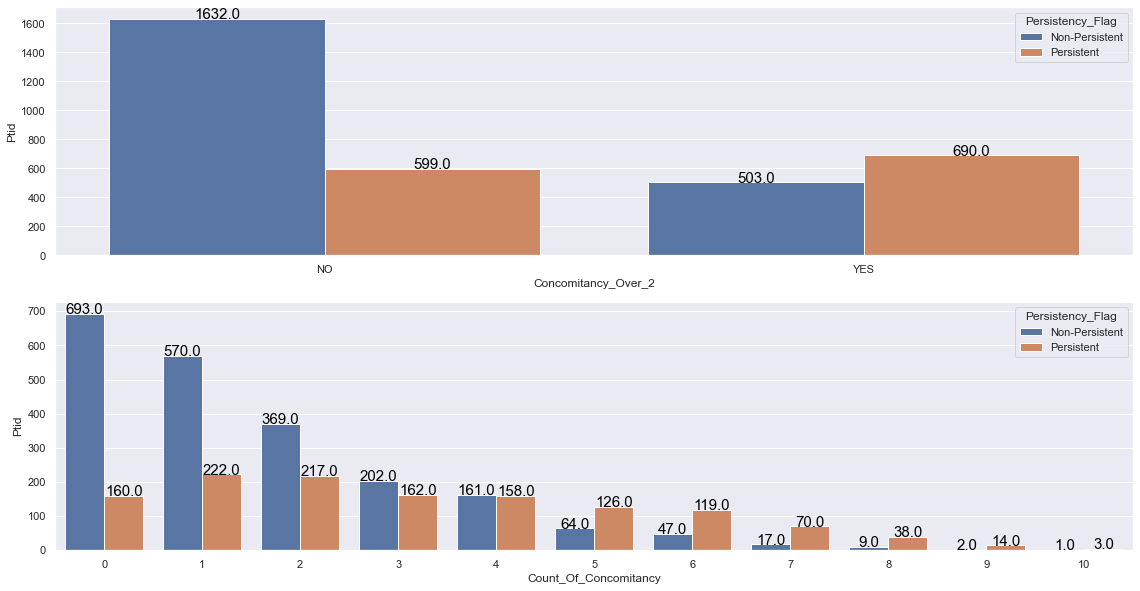

In [62]:
H13 = df4[['Ptid', 'Count_Of_Concomitancy', 'Persistency_Flag']].groupby(['Count_Of_Concomitancy', 'Persistency_Flag']).count().reset_index()

aux_H13 = df4[['Ptid', 'Count_Of_Concomitancy', 'Persistency_Flag']]      
aux_H13['Concomitancy_Over_2'] = aux_H13.apply(lambda x: 'YES' if (x['Count_Of_Concomitancy'] > 2) else
                                                  'NO' , axis = 1)
      
H13_1 = aux_H13[['Ptid', 'Concomitancy_Over_2', 'Persistency_Flag']].groupby(['Concomitancy_Over_2', 'Persistency_Flag']).count().reset_index()

plt.subplot(3,1,1)
plot1 = sns.barplot(x = 'Concomitancy_Over_2', y = 'Ptid', hue = 'Persistency_Flag', data = H13_1);
bar_value(plot1)
plt.tight_layout()

plt.subplot(3,1,2)
plot2 = sns.barplot(x = 'Count_Of_Concomitancy', y = 'Ptid', hue = 'Persistency_Flag', data = H13);
bar_value(plot2)
plt.tight_layout()

The categorical attribute 'Count_Of_Concomitancy' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### **H14.** Patients that presents more than 3 different types of comorbidity are more persistent of a drug than patients that present less than 3 different types of comorbidity.
**TRUE** There are 1055 persistent patients that presents more than 3 different types of comorbidity and 234 persistent patients that do not presents more than 3 different types of comorbidity, which means, there are a difference between both status of 821 persistent patients.

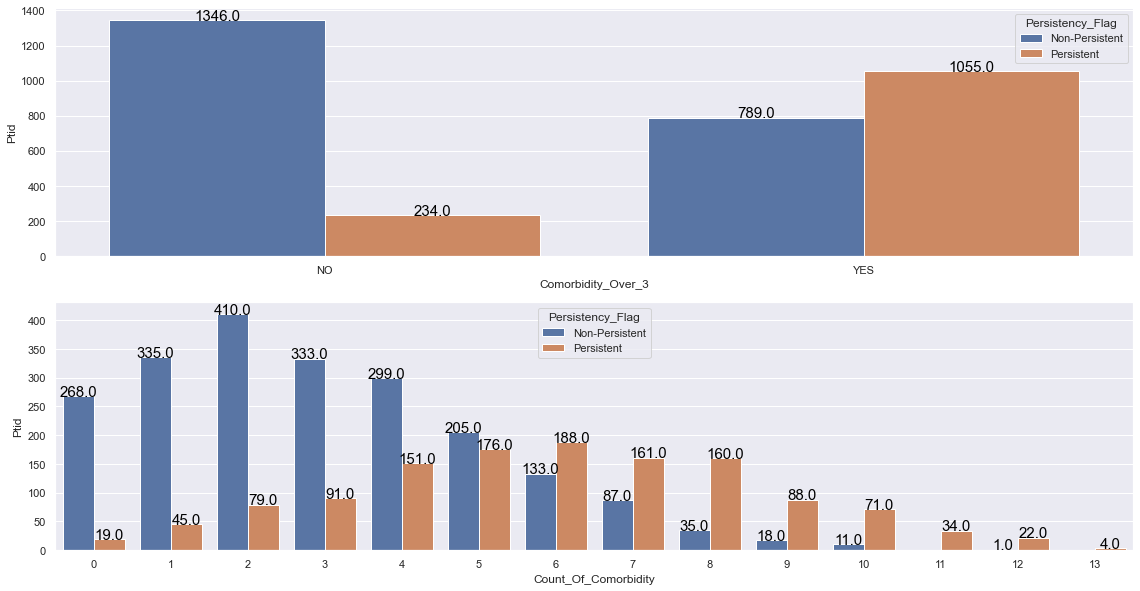

In [63]:
H14 = df4[['Ptid', 'Count_Of_Comorbidity', 'Persistency_Flag']].groupby(['Count_Of_Comorbidity', 'Persistency_Flag']).count().reset_index()

aux_H14 = df4[['Ptid', 'Count_Of_Comorbidity', 'Persistency_Flag']]      
aux_H14['Comorbidity_Over_3'] = aux_H14.apply(lambda x: 'YES' if (x['Count_Of_Comorbidity'] > 3) else
                                                        'NO' , axis = 1)
      
H14_1 = aux_H14[['Ptid', 'Comorbidity_Over_3', 'Persistency_Flag']].groupby(['Comorbidity_Over_3', 'Persistency_Flag']).count().reset_index()

plt.subplot(3,1,1)
plot1 = sns.barplot(x = 'Comorbidity_Over_3', y = 'Ptid', hue = 'Persistency_Flag', data = H14_1);
bar_value(plot1)
plt.tight_layout()

plt.subplot(3,1,2)
plot2 = sns.barplot(x = 'Count_Of_Comorbidity', y = 'Ptid', hue = 'Persistency_Flag', data = H14);
bar_value(plot2)
plt.tight_layout()

The categorical attribute 'Count_Of_Comorbidity' show a well varied behavior, not stagnated, presenting relevant information for the learning of the ML model. In other words, this information can help to obtain more accuracy in the evaluation of the ML model.

### 4.2.1. Summary of Hypotheses.

In [29]:
tab = [['Hipoteses', 'Conclusion', 'Relevance'],
      ['H1', 'True', 'High'],
      ['H2', 'False', 'High'],
      ['H3', 'True', 'High'],
      ['H4', 'True', 'Medium/Medium'],
      ['H5', 'True', 'High'],
      ['H6', 'False', 'Medium'],
      ['H7', 'False', 'High'],
      ['H8', 'False', 'Medium'],
      ['H9', 'False', 'Medium/High'],
      ['H10', 'True', 'High/High'],
      ['H11', 'False', 'High'],
      ['H12', 'True', 'High/High'],
      ['H13', 'False', 'High'],
      ['H14', 'True', 'High']]
print(tabulate(tab,headers = 'firstrow'))

Hipoteses    Conclusion    Relevance
-----------  ------------  -------------
H1           True          High
H2           False         High
H3           True          High
H4           True          Medium/Medium
H5           True          High
H6           False         Medium
H7           False         High
H8           False         Medium
H9           False         Medium/High
H10          True          High/High
H11          False         High
H12          True          High/High
H13          False         High
H14          True          High


### 4.2.2. Final Recommendation.

Based on all the Insights created from this dataset, patients who have a higher probability of persisting of a drug for the entire treatment, have the following characteristics:

Female;

Patients older than 65 years;

Caucasian non-Hispanic Patients;

Patients mapped to IDN;

Patients that received the drug prescription from General Practitioner Specialty;

Patients who did not use Glucocorticoid and had Fragility Fracture;

Patients who had no Dexa Scan;

Patient’s adherent for therapies and that used drugs before the therapy.


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

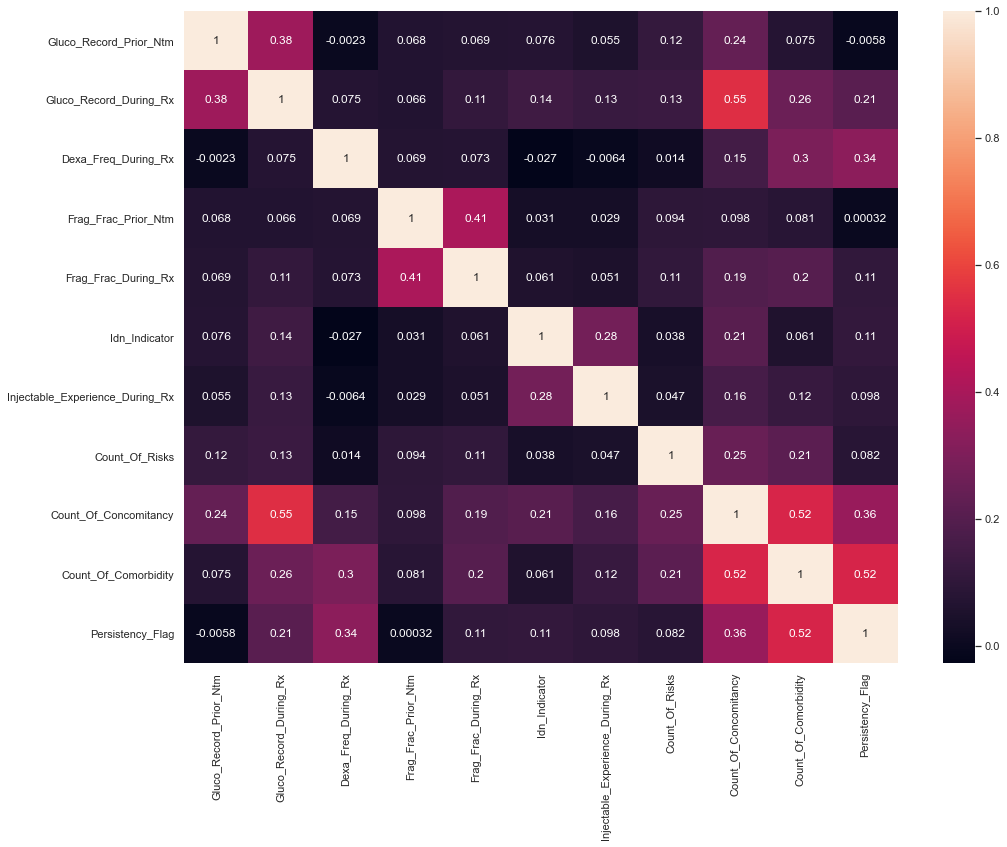

In [84]:
# Replacing all values 'Y' (Yes) and 'N' (No) for 1 (Yes) and 0 (No), of all categorical attributes that has those values.
num_attributes = df4.replace('Y', 1).replace('N', 0)
num_attributes = num_attributes.select_dtypes(include=['int64', 'float64'])
num_attributes['Persistency_Flag'] = df4['Persistency_Flag']
num_attributes['Persistency_Flag'] = num_attributes.apply(lambda x: 1 if (x['Persistency_Flag'] == 'Persistent') else
                                                                    0 , axis = 1)

num_attributes.drop(num_attributes.iloc[:, 7:50], inplace = True, axis = 1)

correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

# the closer the color black the higher the negative correlation
# the closer the color white the higher the positive correlation

# pearson method only used on numerical variables

In [37]:
cat_attributes = df4.replace('Y', 1).replace('N', 0)
cat_attributes = cat_attributes.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
cat_attributes

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,P3420,Persistent,Female,Caucasian,Not Hispanic,South,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent
3420,P3421,Persistent,Female,Caucasian,Not Hispanic,South,>75,Unknown,Others,OB/GYN/Others/PCP/Unknown,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Non-Adherent
3421,P3422,Persistent,Female,Caucasian,Not Hispanic,South,>75,ENDOCRINOLOGY,Specialist,Endo/Onc/Uro,VLR_LR,>-2.5,HR_VHR,<=-2.5,No change,Worsened,Adherent
3422,P3423,Non-Persistent,Female,Caucasian,Not Hispanic,South,55-65,Unknown,Others,OB/GYN/Others/PCP/Unknown,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent


# 5.0. STEP 05 - DATA PREPARATION

In [29]:
df5 = df4.copy()

## 5.1. Normalization

In [30]:
num_attributes1 = df5.select_dtypes(include=['int64','float64'])

In [31]:
num_attributes1.head()

,Dexa_Freq_During_Rx,Count_Of_Risks,Count_Of_Concomitancy,Count_Of_Comorbidity
0,0,0,0,5
1,0,0,0,1
2,0,2,1,2
3,0,1,3,6
4,0,1,3,5


In [32]:
descriptive_num_attributes(num_attributes1)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Dexa_Freq_During_Rx,0.000,146.000,146.000,3.016,0.000,8.135,6.809,74.758
1,Count_Of_Risks,0.000,7.000,7.000,1.239,1.000,1.095,0.880,0.900
2,Count_Of_Concomitancy,0.000,10.000,10.000,2.175,2.000,2.094,1.010,0.389
3,Count_Of_Comorbidity,0.000,13.000,13.000,4.098,4.000,2.779,0.527,-0.325


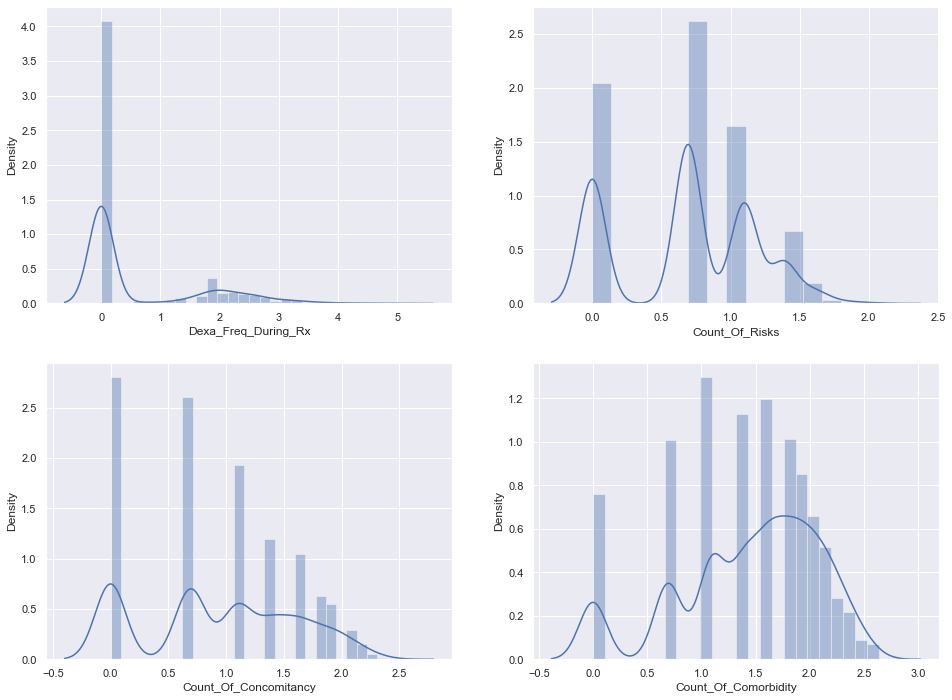

In [33]:
# Normal Distribution Check

# Dexa_Freq_During_Rx
plt.subplot(2,2,1)
sns.distplot(np.log1p(num_attributes1['Dexa_Freq_During_Rx']));

# Count_Of_Risks
plt.subplot(2,2,2)
sns.distplot(np.log1p(num_attributes1['Count_Of_Risks']));

# 	Count_Of_Concomitancys
plt.subplot(2,2,3)
sns.distplot(np.log1p(num_attributes1['Count_Of_Concomitancy']));

# Count_Of_Risks
plt.subplot(2,2,4)
sns.distplot(np.log1p(num_attributes1['Count_Of_Comorbidity']));

The range of the variable 'Dexa_Freq_During_Rx' is very different from the others variables, wich it can be influenciable on the ML model. 
To solve this it is necessery rescale the variables.

Since there are no numerical variables with normal distribution, normalization is not used then.

## 5.2. Rescaling

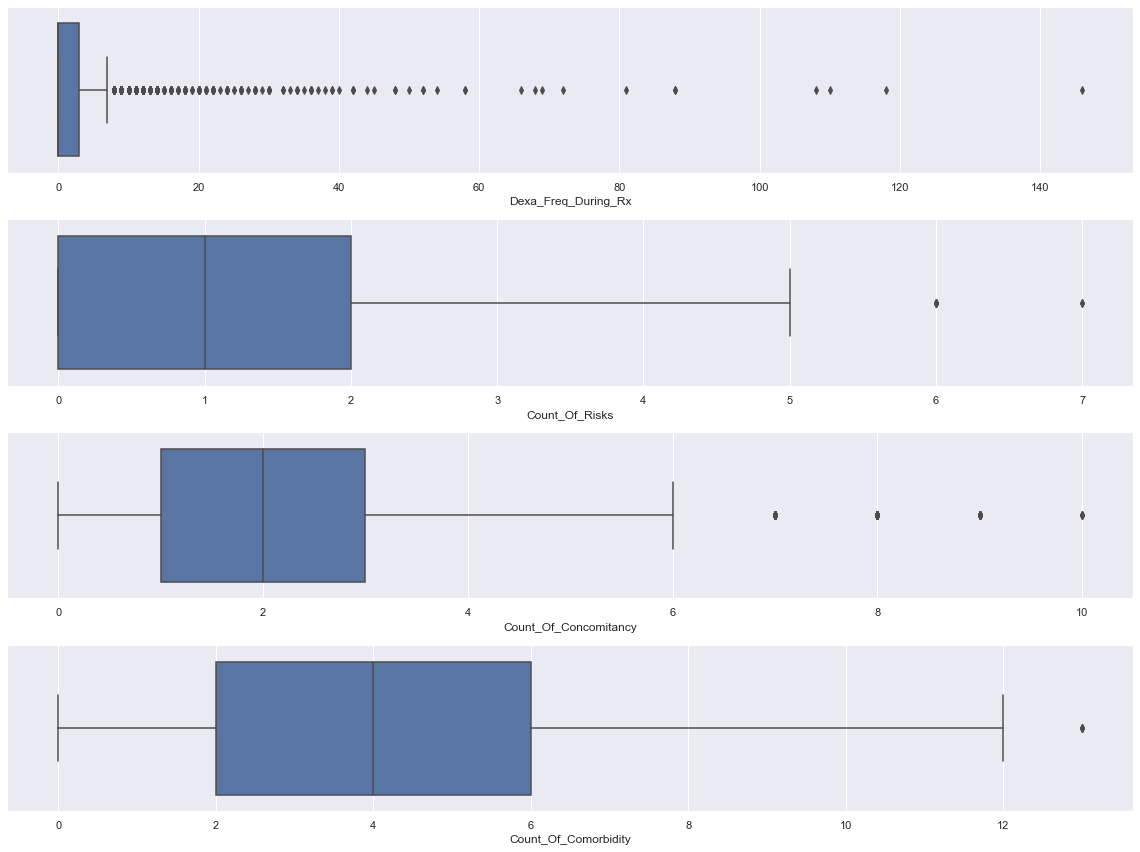

In [34]:
# Dexa_Freq_During_Rx
plt.subplot(4,1,1)
sns.boxplot(df5['Dexa_Freq_During_Rx'])
plt.tight_layout()
# use the robust scaler because it has many outliers

# Count_Of_Risks
plt.subplot(4,1,2)
sns.boxplot(df5['Count_Of_Risks'])
plt.tight_layout()
# use the Min-Max scaler because it does not have too many outliers

# Count_Of_Concomitancy
plt.subplot(4,1,3)
sns.boxplot(df5['Count_Of_Concomitancy'])
plt.tight_layout()
# use the Min-Max scaler because it does not have too many outliers

# Count_Of_Comorbidity
plt.subplot(4,1,4)
sns.boxplot(df5['Count_Of_Comorbidity'])
plt.tight_layout()
# use the Min-Max scaler because it does not have too many outliers

In [35]:
# all numerical variables with non-cyclical nature
rs = RobustScaler()
mms = MinMaxScaler()

# Dexa_Freq_During_Rx uses Robust Scaler
df5['Dexa_Freq_During_Rx'] = rs.fit_transform(df5[['Dexa_Freq_During_Rx']])
pickle.dump(rs, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Dexa_Freq_During_Rx_scaler.pkl', 'wb'))

# Count_Of_Risks uses uses Min-Max Scaler
df5['Count_Of_Risks'] = mms.fit_transform(df5[['Count_Of_Risks']])
pickle.dump(mms, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Count_Of_Risks_scaler.pkl', 'wb'))

# Count_Of_Concomitancy uses Min-Max Scaler
df5['Count_Of_Concomitancy'] = mms.fit_transform(df5[['Count_Of_Concomitancy']])
pickle.dump(mms, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Count_Of_Concomitancy_scaler.pkl', 'wb'))

# Count_Of_Comorbidity uses Min-Max Scaler
df5['Count_Of_Comorbidity'] = mms.fit_transform(df5[['Count_Of_Comorbidity']])
pickle.dump(mms, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Count_Of_Comorbidity_scaler.pkl', 'wb'))

## 5.3. TRansformation

### 5.3.1. Encoding

In [36]:
b = df5.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
b

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,P3420,Persistent,Female,Caucasian,Not Hispanic,South,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,Y,Y,Y,N,Y,Y,N,N,N,Y,N,Y,Y,N,N,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N
3420,P3421,Persistent,Female,Caucasian,Not Hispanic,South,>75,Unknown,Others,OB/GYN/Others/PCP/Unknown,N,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Non-Adherent

In [37]:
# Categorical Variables

# Categorical attributes that presents binary values as 'Y' and 'N', the method Label Encoding will be used in order to
# transfoer 'Y' and 'N' values into 1 and 0 respectively.

df5 = df5.replace('Y', 1).replace('N', 0)


# Categorical attributes that presents binary values also will be use the method  Label Encoding
le = LabelEncoder()

# Persistency_Flag (Persistent = 1, Non-Persistent = 0)
df5['Persistency_Flag'] = le.fit_transform(df5['Persistency_Flag'])
pickle.dump(le, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Persistency_Flag_scaler.pkl', 'wb'))

# Gender (Male = 1, Female = 0)
df5['Gender'] = le.fit_transform(df5['Gender'])
pickle.dump(le, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Gender_scaler.pkl', 'wb'))

# Ntm_Specialist_Flag (Specialist = 1, Others = 0)
df5['Ntm_Specialist_Flag'] = le.fit_transform(df5['Ntm_Specialist_Flag'])
pickle.dump(le, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Ntm_Specialist_Flag_scaler.pkl', 'wb'))

# Risk_Segment_Prior_Ntm (VLR_LR = 1, HR_VHR = 0)
df5['Risk_Segment_Prior_Ntm'] = le.fit_transform(df5['Risk_Segment_Prior_Ntm'])
pickle.dump(le, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Risk_Segment_Prior_Ntm_scaler.pkl', 'wb'))

# Adherent_Flag (Non-Adherent = 1, Adherent = 0)
df5['Adherent_Flag'] = le.fit_transform(df5['Adherent_Flag'])
pickle.dump(le, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Adherent_Flag_scaler.pkl', 'wb'))


# Categorical attributes that presents order or scale will be use the method  Ordinal Encoding

# Age_Bucket
Age_Bucket_dict = {'<55' : 1, '55-65' : 2, '65-75' : 3, '>75' : 4}
df5['Age_Bucket'] = df5['Age_Bucket'].map(Age_Bucket_dict)

# Tscore_Bucket_Prior_Ntm (>-2.5 = 1, <=-2.5 = 0)
Tscore_Bucket_Prior_Ntm_dict = {'<=-2.5' : 1, '>-2.5' : 2}
df5['Tscore_Bucket_Prior_Ntm'] = df5['Tscore_Bucket_Prior_Ntm'].map(Tscore_Bucket_Prior_Ntm_dict)


# Categorical attributes that do not presents order or scale or idea os state, each value is independent, 
# will be use the method  Label Encoding

# Race
df5['Race'] = le.fit_transform(df5['Race'])
pickle.dump(le, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Race_scaler.pkl', 'wb'))

# Ethnicity
df5['Ethnicity'] = le.fit_transform(df5['Ethnicity'])
pickle.dump(le, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Ethnicity_scaler.pkl', 'wb'))

# Region
df5['Region'] = le.fit_transform(df5['Region'])
pickle.dump(le, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Region_scaler.pkl', 'wb'))

# Ntm_Speciality_Bucket
df5['Ntm_Speciality_Bucket'] = le.fit_transform(df5['Ntm_Speciality_Bucket'])
pickle.dump(le, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Ntm_Speciality_Bucket_scaler.pkl', 'wb'))

# Risk_Segment_During_Rx
df5['Risk_Segment_During_Rx'] = le.fit_transform(df5['Risk_Segment_During_Rx'])
pickle.dump(le, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Risk_Segment_During_Rx_scaler.pkl', 'wb'))

# Tscore_Bucket_During_Rx
df5['Tscore_Bucket_During_Rx'] = le.fit_transform(df5['Tscore_Bucket_During_Rx'])
pickle.dump(le, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Tscore_Bucket_During_Rx_scaler.pkl', 'wb'))


# Categorical attributes that presents an idea os state, will be use the method  One Hot Encoding

# Change_T_Score
df5 = pd.get_dummies(df5,prefix=['Change_T_Score'], columns=['Change_T_Score'])

# Change_Risk_Segment
df5 = pd.get_dummies(df5,prefix=['Change_Risk_Segment'], columns=['Change_Risk_Segment'])


# Categorical attributes that presents a huge amount of values, will be use the method  Target Encoding
encoder = TargetEncoder()

# Ntm_Speciality
df5['Ntm_Speciality'] = encoder.fit_transform(df5['Ntm_Speciality'], df5['Persistency_Flag'])
pickle.dump(encoder, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Ntm_Speciality_scaler.pkl', 'wb'))

In [38]:
df5.head()

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,Count_Of_Concomitancy,Count_Of_Comorbidity,Change_T_Score_Improved,Change_T_Score_No change,Change_T_Score_Unknown,Change_T_Score_Worsened,Change_Risk_Segment_Improved,Change_Risk_Segment_No change,Change_Risk_Segment_Unknown,Change_Risk_Segment_Worsened
0,P1,1,1,2,1,4,4,0.322,0,1,0,0,0.000,0,0,1,2,2,0,0,0,1,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.385,0,1,0,0,0,0,1,0
1,P2,0,1,1,1,4,2,0.322,0,1,0,0,0.000,0,0,1,2,1,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.077,0,0,1,0,0,0,1,0
2,P3,0,0,3,0,0,3,0.322,0,1,0,0,0.000,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.286,0.100,0.154,0,1,0,0,0,1,0,0
3,P4,0,0,2,1,0,4,0.322,0,1,0,1,0.000,0,0,0,2,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.143,0.300,0.462,0,1,0,0,0,1,0,0
4,P5,0,0,2,1,0,4,0.322,0,1,1,1,0.000,0,0,0,1,1,2,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.143,0.300,0.385,0,0,1,0,0,0,1,0


# 6.0. STEP 06 - FEATURE SELECTION

In [39]:
df6 = df5.copy()

## 6.1. Split Dataframe Into Prediction Variables & Target Variable

In [40]:
# first delete original variables that originated derived variables, they are deleted because they contain the same information
# as the derivatives.

# Attributes to exclude after encoding
cols_drop = ['Ptid']
df6 = df6.drop(cols_drop, axis=1)

In [41]:
# split Prediction Variables & Target Variable
X = df6.drop(columns = 'Persistency_Flag', axis = 1)
Y = df6['Persistency_Flag']

## 6.2. Boruta as Feature Selector

In [42]:
# split data 
X_train_n = X.values
Y_train_n = Y.values.ravel()

# define model
extra_model = ExtraTreesClassifier(n_jobs=-1)
# rf = RandomForestClassifier(n_jobs = -1) testar depois

# define boruta
boruta = BorutaPy(extra_model, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, Y_train_n)
#pickle.dump(boruta, open('/content/drive/My Drive/syn_finan/fraud_detect/parameter/boruta_parameter.pkl', 'wb'))
#boruta = pickle.load(open('syn_finan/fraud_detect/parameter/boruta_parameter.pkl', 'rb'))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	74
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	74
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	74
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	74
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	74
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	74
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	74
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	22
Tentative: 	6
Rejected: 	46
Iteration: 	9 / 100
Confirmed: 	22
Tentative: 	6
Rejected: 	46
Iteration: 	10 / 100
Confirmed: 	22
Tentative: 	6
Rejected: 	46
Iteration: 	11 / 100
Confirmed: 	22
Tentative: 	6
Rejected: 	46
Iteration: 	12 / 100
Confirmed: 	22
Tentative: 	6
Rejected: 	46
Iteration: 	13 / 100
Confirmed: 	22
Tentative: 	5
Rejected: 	47
Iteration: 	14 / 100
Confirmed: 	22
Tentative: 	5
Rejected: 	47
Iteration: 	15 / 100
Confirmed: 	22
Tentative: 	5
Rejected: 	47
Iteration: 	16 / 100
Confirmed: 	22
Tentative: 	5
Reject

### 6.2.1 Best Features from Boruta

In [43]:
# best features from boruta
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

# select the variables it ranks as most relevant
cols_selected = boruta.support_.tolist() #  show the values of each column, ranking from 1 (most relevant) to 2, 3, 4, etc

# best features 
cols_selected_boruta = X.iloc[:, cols_selected].columns.to_list() # showing the name of the columns in the rank

# not selected boruta 
cols_not_selected_boruta = list(np.setdiff1d(X.columns, cols_selected_boruta))

In [44]:
# list of columns selected by boruta
cols_selected_boruta

['Region',
 'Ntm_Speciality',
 'Ntm_Speciality_Bucket',
 'Dexa_Freq_During_Rx',
 'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
 'Comorb_Encounter_For_Immunization',
 'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
 'Comorb_Vitamin_D_Deficiency',
 'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
 'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
 'Comorb_Long_Term_Current_Drug_Therapy',
 'Comorb_Dorsalgia',
 'Comorb_Personal_History_Of_Other_Diseases_And_Conditions',
 'Comorb_Other_Disorders_Of_Bone_Density_And_Structure',
 'Comorb_Gastro_esophageal_reflux_disease',
 'Concom_Systemic_Corticosteroids_Plain',
 'Concom_Cephalosporins',
 'Concom_Macrolides_And_Similar_Types',
 'Concom_Anaesthetics_General',
 'Concom_Viral_Vaccines',
 'Count_Of_Concomitancy',
 'Count_Of_Comorbidity']

In [45]:
# list of columns not selected by boruta
cols_not_selected_boruta

['Adherent_Flag',
 'Age_Bucket',
 'Change_Risk_Segment_Improved',
 'Change_Risk_Segment_No change',
 'Change_Risk_Segment_Unknown',
 'Change_Risk_Segment_Worsened',
 'Change_T_Score_Improved',
 'Change_T_Score_No change',
 'Change_T_Score_Unknown',
 'Change_T_Score_Worsened',
 'Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias',
 'Comorb_Osteoporosis_without_current_pathological_fracture',
 'Comorb_Personal_history_of_malignant_neoplasm',
 'Concom_Anti_Depressants_And_Mood_Stabilisers',
 'Concom_Broad_Spectrum_Penicillins',
 'Concom_Cholesterol_And_Triglyceride_Regulating_Preparations',
 'Concom_Fluoroquinolones',
 'Concom_Narcotics',
 'Count_Of_Risks',
 'Ethnicity',
 'Frag_Frac_During_Rx',
 'Frag_Frac_Prior_Ntm',
 'Gender',
 'Gluco_Record_During_Rx',
 'Gluco_Record_Prior_Ntm',
 'Idn_Indicator',
 'Injectable_Experience_During_Rx',
 'Ntm_Specialist_Flag',
 'Race',
 'Risk_Chronic_Liver_Disease',
 'Risk_Chronic_Malnutrition_Or_Malabsorption',
 'Risk_Estrogen_Deficiency',
 'R

## 6.3. Manual Feature Selection

In [46]:
cols_selected_boruta = ['Region',
 'Ntm_Speciality_Bucket',
 'Dexa_Freq_During_Rx',
 'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
 'Comorb_Encounter_For_Immunization',
 'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
 'Comorb_Vitamin_D_Deficiency',
 'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
 'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
 'Comorb_Long_Term_Current_Drug_Therapy',
 'Comorb_Dorsalgia',
 'Comorb_Personal_History_Of_Other_Diseases_And_Conditions',
 'Comorb_Other_Disorders_Of_Bone_Density_And_Structure',
 'Comorb_Gastro_esophageal_reflux_disease',
 'Concom_Systemic_Corticosteroids_Plain',
 'Concom_Cephalosporins',
 'Concom_Macrolides_And_Similar_Types',
 'Concom_Anaesthetics_General',
 'Concom_Viral_Vaccines',
 'Count_Of_Concomitancy',
 'Count_Of_Comorbidity']

# columns to add
feat_to_add = ['Persistency_Flag']

# final features

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [47]:
cols_selected_boruta_full

['Region',
 'Ntm_Speciality_Bucket',
 'Dexa_Freq_During_Rx',
 'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
 'Comorb_Encounter_For_Immunization',
 'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
 'Comorb_Vitamin_D_Deficiency',
 'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
 'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
 'Comorb_Long_Term_Current_Drug_Therapy',
 'Comorb_Dorsalgia',
 'Comorb_Personal_History_Of_Other_Diseases_And_Conditions',
 'Comorb_Other_Disorders_Of_Bone_Density_And_Structure',
 'Comorb_Gastro_esophageal_reflux_disease',
 'Concom_Systemic_Corticosteroids_Plain',
 'Concom_Cephalosporins',
 'Concom_Macrolides_And_Similar_Types',
 'Concom_Anaesthetics_General',
 'Concom_Viral_Vaccines',
 'Count_Of_Concomitancy',
 'Count_Of_Comorbidity',
 'Persistency_Flag']

# 7.0. STEP 07 - MACHINE LEARNING MODELLING

In [84]:
df7 = df6[cols_selected_boruta_full].copy()
df7

,Region,Ntm_Speciality_Bucket,Dexa_Freq_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Gastro_esophageal_reflux_disease,Concom_Systemic_Corticosteroids_Plain,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Count_Of_Concomitancy,Count_Of_Comorbidity,Persistency_Flag
0,4,1,0.000,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0.000,0.385,1
1,4,1,0.000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.077,0
2,0,1,0.000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.100,0.154,0
3,0,1,0.000,0,1,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0.300,0.462,0
4,0,1,0.000,1,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0.300,0.385,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,3,1,0.000,1,0,1,1,0,0,0,1,0,1,1,1,0,0,0,0,0.500,0.538,1
3420,3,1,0.000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.200,0.000,1
3421,3,0,2.333,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0.300,0.308,1
3422,3,1,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.200,0.154,0


In [85]:
df7.value_counts('Persistency_Flag')

Persistency_Flag
0    2135
1    1289
dtype: int64

### 7.0.1 Spliting Dataset into Target Variablen (y) and Features (X) for Cols_Selected_Boruta_Full

In [86]:
# target variable and features split cols_selected_boruta_full
X = df7.drop(columns = 'Persistency_Flag', axis = 1)
y = df7['Persistency_Flag']

In [87]:
# Numer of rows before dataset balanced
print(X.shape, end='\n\n')
print(y.shape)

(3424, 21)

(3424,)


In [88]:
# The quantity of each value (0 and 1) of the variable 'Persistency_Flag' before dataset balanced
np.bincount(y)

array([2135, 1289], dtype=int64)

### 7.0.2 Balancing Dataset

In [89]:
nr = NearMiss()

In [90]:
X, y = nr.fit_resample(X, y)

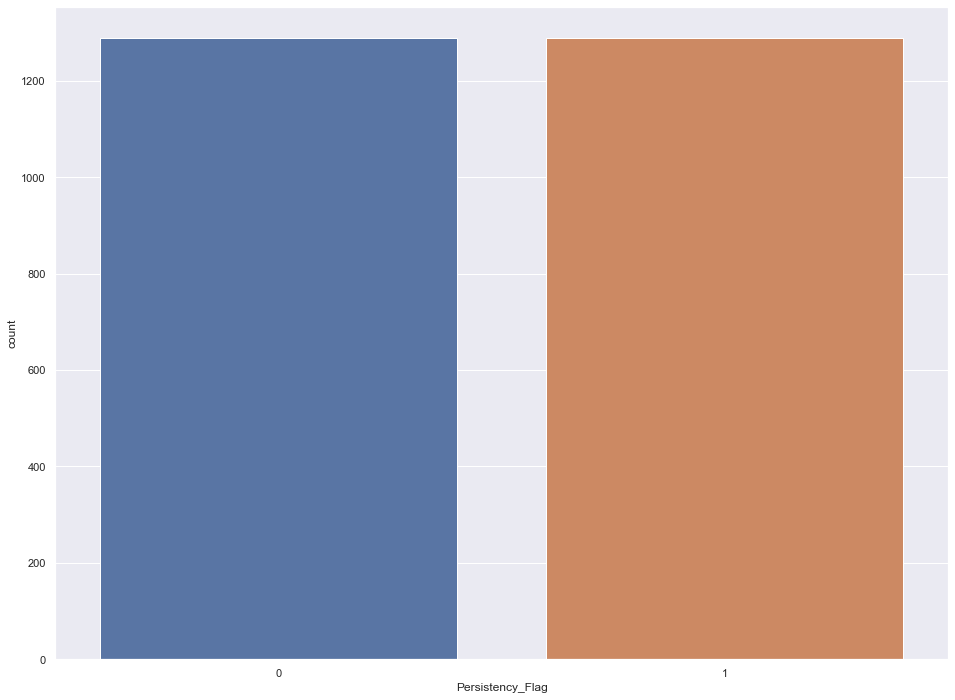

In [91]:
ax = sns.countplot(x=y)

In [92]:
# Numer of rows after dataset balanced
print(X.shape, end='\n\n')
print(y.shape)

(2578, 21)

(2578,)


In [93]:
# The quantity of each value (0 and 1) of the variable 'Persistency_Flag' after dataset balanced
np.bincount(y)

array([1289, 1289], dtype=int64)

### 7.0.3 Spliting Dataset into Train and Test

In [94]:
#train test split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [95]:
# The quantity of each value (0 and 1) of the variable 'Persistency_Flag' after dataset balanced, for y_train
np.bincount(y_train)

array([911, 893], dtype=int64)

In [96]:
# The quantity of each value (0 and 1) of the variable 'Persistency_Flag' after dataset balanced, for y_test
np.bincount(y_test)

array([378, 396], dtype=int64)

## 7.1. Extra Trees Classifier Model

In [97]:
# model
et = ExtraTreesClassifier(n_jobs=-1, random_state = 42)

# train_model
et.fit(X_train.values, y_train.values)

# prediction
yhat_et = et.predict(X_test)

# performance
result_et = pd.DataFrame(["Extra Trees Classifier",accuracy_score(y_test,yhat_et),
                            cohen_kappa_score(y_test,yhat_et),
                            recall_score(y_test,yhat_et), 
                            f1_score(y_test,yhat_et),
                            precision_score(y_test,yhat_et)]).T
result_et.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

# classification_report
print(classification_report(y_test, yhat_et))

result_et

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       378
           1       0.89      0.82      0.85       396

    accuracy                           0.86       774
   macro avg       0.86      0.86      0.86       774
weighted avg       0.86      0.86      0.86       774



,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Extra Trees Classifier,0.857,0.714,0.823,0.855,0.888


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

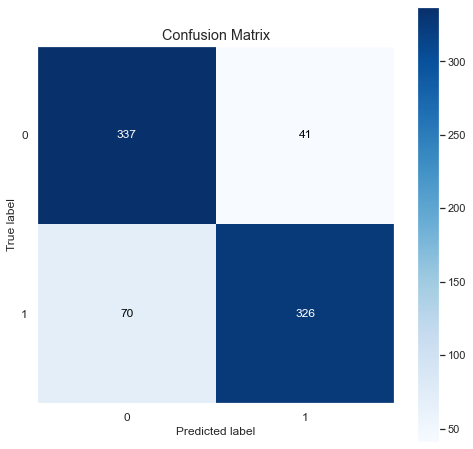

In [98]:
mt.plot_confusion_matrix(y_test, yhat_et, normalize = False, figsize = (8,8))

### 7.1.1 Extra Trees Classifier Model - Cross - Validation

In [99]:
scoring = ['accuracy', 'recall', 'f1', 'precision']
et_cv = cross_validate(et, X_train.values, y_train.ravel(), cv = 10, n_jobs = -1, scoring= scoring)

cv_result_et = pd.DataFrame({'Model Name': ["Extra Trees Classifier"],
                                     'Average Accuracy CV' : [np.round(np.mean(et_cv['test_accuracy']),4).astype(str) + ' +/- ' + np.round(np.std(et_cv['test_accuracy']),6).astype(str)],
                                     'Average Recall CV'   : [np.round(np.mean(et_cv['test_recall']),4).astype(str) + ' +/- ' + np.round(np.std(et_cv['test_recall']),6).astype(str)],
                                     'Average F1 CV'       : [np.round(np.mean(et_cv['test_f1']),4).astype(str) + ' +/- ' + np.round(np.std(et_cv['test_f1']),6).astype(str)],
                                     'Average Precision CV': [np.round(np.mean(et_cv['test_precision']),4).astype(str) + ' +/- ' + np.round(np.std(et_cv['test_precision']),6).astype(str)]})


cv_result_et

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,Extra Trees Classifier,0.8653 +/- 0.03444,0.8388 +/- 0.035868,0.8607 +/- 0.034804,0.8847 +/- 0.045701


## 7.2. LGBM Classifier Model

In [100]:
# model
lgbm = LGBMClassifier(n_jobs = -1)

# train_model
lgbm.fit(X_train.values, y_train.values)

# prediction
yhat_lgbm = lgbm.predict(X_test)

# performance
result_lgbm = pd.DataFrame(["LGBM Classifier",accuracy_score(y_test,yhat_lgbm),
                            cohen_kappa_score(y_test,yhat_lgbm),
                            recall_score(y_test,yhat_lgbm), 
                            f1_score(y_test,yhat_lgbm),
                            precision_score(y_test,yhat_lgbm)]).T
result_lgbm.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

# classification_report
print(classification_report(y_test, yhat_lgbm))

result_lgbm

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       378
           1       0.91      0.82      0.86       396

    accuracy                           0.86       774
   macro avg       0.87      0.86      0.86       774
weighted avg       0.87      0.86      0.86       774



,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,LGBM Classifier,0.863,0.727,0.818,0.859,0.905


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

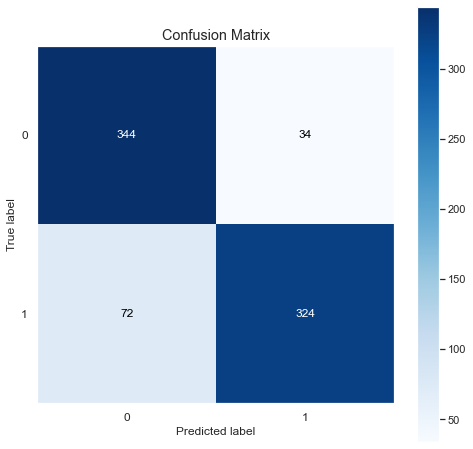

In [101]:
mt.plot_confusion_matrix(y_test, yhat_lgbm, normalize = False, figsize = (8,8))

### 7.2.1 LGBM Classifier Model - Cross - Validation

In [102]:
scoring = ['accuracy', 'recall', 'f1', 'precision']
lgbm_cv = cross_validate(lgbm, X_train.values, y_train.ravel(), cv = 10, n_jobs = -1, scoring= scoring)

cv_result_lgbm = pd.DataFrame({'Model Name': ["LGBM Classifier"],
                                     'Average Accuracy CV' : [np.round(np.mean(lgbm_cv['test_accuracy']),4).astype(str) + ' +/- ' + np.round(np.std(lgbm_cv['test_accuracy']),6).astype(str)],
                                     'Average Recall CV'   : [np.round(np.mean(lgbm_cv['test_recall']),4).astype(str) + ' +/- ' + np.round(np.std(lgbm_cv['test_recall']),6).astype(str)],
                                     'Average F1 CV'       : [np.round(np.mean(lgbm_cv['test_f1']),4).astype(str) + ' +/- ' + np.round(np.std(lgbm_cv['test_f1']),6).astype(str)],
                                     'Average Precision CV': [np.round(np.mean(lgbm_cv['test_precision']),4).astype(str) + ' +/- ' + np.round(np.std(lgbm_cv['test_precision']),6).astype(str)]})


cv_result_lgbm

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,LGBM Classifier,0.8776 +/- 0.034981,0.8445 +/- 0.046638,0.872 +/- 0.037179,0.9029 +/- 0.041209


## 7.3. Stochastic Gradient Descent Model

In [103]:
# model
sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=5, random_state = 42)

 #train_model
sgd.fit(X_train.values, y_train.values)

# prediction
yhat_sgd = sgd.predict(X_test)

# performance
result_sgd = pd.DataFrame(["SGD Classifier",accuracy_score(y_test,yhat_sgd),
                            cohen_kappa_score(y_test,yhat_sgd),
                            recall_score(y_test,yhat_sgd), 
                            f1_score(y_test,yhat_sgd),
                            precision_score(y_test,yhat_sgd)]).T
result_sgd.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

# classification_report
print(classification_report(y_test, yhat_sgd))

result_sgd

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       378
           1       0.90      0.87      0.88       396

    accuracy                           0.88       774
   macro avg       0.88      0.88      0.88       774
weighted avg       0.88      0.88      0.88       774



,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,SGD Classifier,0.881,0.762,0.866,0.882,0.898


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

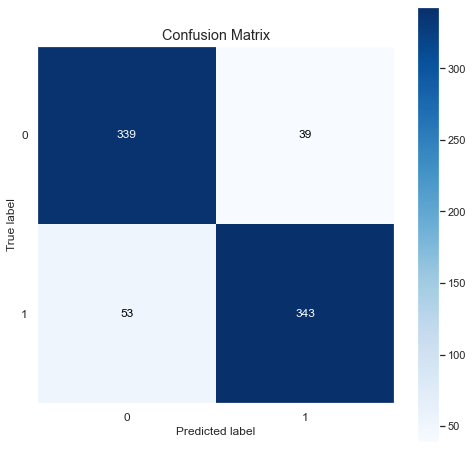

In [104]:
mt.plot_confusion_matrix(y_test, yhat_sgd, normalize = False, figsize = (8,8))

### 7.3.1 Stochastic Gradient Descent Model - Cross - Validation

In [105]:
scoring = ['accuracy', 'recall', 'f1', 'precision']
sgd_cv = cross_validate(sgd, X_train.values, y_train.ravel(), cv = 10, n_jobs = -1, scoring= scoring)

cv_result_sgd = pd.DataFrame({'Model Name': ["SGD Classifie"],
                                     'Average Accuracy CV' : [np.round(np.mean(sgd_cv['test_accuracy']),4).astype(str) + ' +/- ' + np.round(np.std(sgd_cv['test_accuracy']),6).astype(str)],
                                     'Average Recall CV'   : [np.round(np.mean(sgd_cv['test_recall']),4).astype(str) + ' +/- ' + np.round(np.std(sgd_cv['test_recall']),6).astype(str)],
                                     'Average F1 CV'       : [np.round(np.mean(sgd_cv['test_f1']),4).astype(str) + ' +/- ' + np.round(np.std(sgd_cv['test_f1']),6).astype(str)],
                                     'Average Precision CV': [np.round(np.mean(sgd_cv['test_precision']),4).astype(str) + ' +/- ' + np.round(np.std(sgd_cv['test_precision']),6).astype(str)]})


cv_result_sgd

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,SGD Classifie,0.8548 +/- 0.030741,0.7996 +/- 0.098789,0.842 +/- 0.044598,0.9031 +/- 0.049891


## 7.4. Random Forest Classifier Model

In [106]:
# model
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 42)

# train_model
rf.fit(X_train.values, y_train.values)

# prediction
yhat_rf = rf.predict(X_test)

# performance
result_rf = pd.DataFrame(["Random Forest Classifier",accuracy_score(y_test,yhat_rf),
                            cohen_kappa_score(y_test,yhat_rf),
                            recall_score(y_test,yhat_rf), 
                            f1_score(y_test,yhat_rf),
                            precision_score(y_test,yhat_rf)]).T
result_rf.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

# classification_report
print(classification_report(y_test, yhat_rf))

result_rf

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       378
           1       0.92      0.83      0.87       396

    accuracy                           0.87       774
   macro avg       0.88      0.87      0.87       774
weighted avg       0.88      0.87      0.87       774



,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Random Forest Classifier,0.873,0.747,0.828,0.870,0.916


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

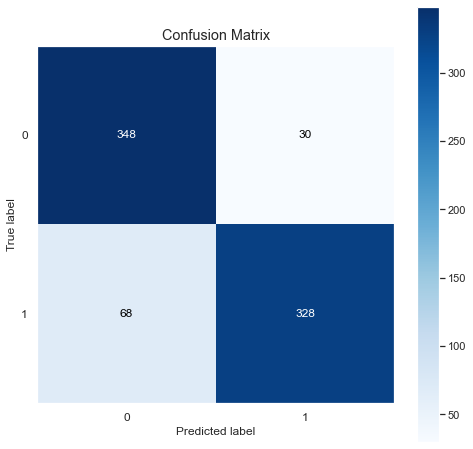

In [107]:
mt.plot_confusion_matrix(y_test, yhat_rf, normalize = False, figsize = (8,8))

### 7.4.1 Random Forest Classifier Model - Cross - Validation

In [108]:
scoring = ['accuracy', 'recall', 'f1', 'precision']
rf_cv = cross_validate(rf, X_train.values, y_train.ravel(), cv = 10, n_jobs = -1, scoring= scoring)

cv_result_rf = pd.DataFrame({'Model Name': ["Random Forest Classifier"],
                                     'Average Accuracy CV' : [np.round(np.mean(rf_cv['test_accuracy']),4).astype(str) + ' +/- ' + np.round(np.std(rf_cv['test_accuracy']),6).astype(str)],
                                     'Average Recall CV'   : [np.round(np.mean(rf_cv['test_recall']),4).astype(str) + ' +/- ' + np.round(np.std(rf_cv['test_recall']),6).astype(str)],
                                     'Average F1 CV'       : [np.round(np.mean(rf_cv['test_f1']),4).astype(str) + ' +/- ' + np.round(np.std(rf_cv['test_f1']),6).astype(str)],
                                     'Average Precision CV': [np.round(np.mean(rf_cv['test_precision']),4).astype(str) + ' +/- ' + np.round(np.std(rf_cv['test_precision']),6).astype(str)]})


cv_result_rf

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,Random Forest Classifier,0.8731 +/- 0.033959,0.8523 +/- 0.036796,0.8694 +/- 0.034474,0.8882 +/- 0.043556


## 7.5. Support Vector Machine Model

In [109]:
# model
svm = SVC(kernel='rbf')

# train_model
svm.fit(X_train.values, y_train.values)

# prediction
yhat_svm = svm.predict(X_test)

# performance
result_svm = pd.DataFrame(["Support Vector Machine",accuracy_score(y_test,yhat_svm),
                            cohen_kappa_score(y_test,yhat_svm),
                            recall_score(y_test,yhat_svm), 
                            f1_score(y_test,yhat_svm),
                            precision_score(y_test,yhat_svm)]).T
result_svm.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

# classification_report
print(classification_report(y_test, yhat_svm))

result_svm

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       378
           1       0.95      0.83      0.88       396

    accuracy                           0.89       774
   macro avg       0.89      0.89      0.89       774
weighted avg       0.89      0.89      0.89       774



,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Support Vector Machine,0.886,0.773,0.826,0.881,0.945


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

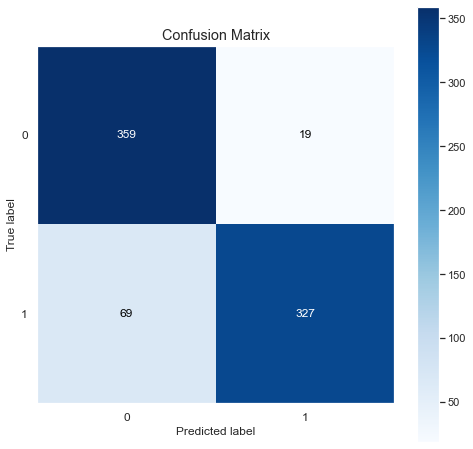

In [110]:
mt.plot_confusion_matrix(y_test, yhat_svm, normalize = False, figsize = (8,8))

### 7.5.1 Support Vector Machine Model - Cross - Validation

In [111]:
scoring = ['accuracy', 'recall', 'f1', 'precision']
svm_cv = cross_validate(svm, X_train.values, y_train.ravel(), cv = 10, n_jobs = -1, scoring= scoring)

cv_result_svm = pd.DataFrame({'Model Name': ["Support Vector Machine"],
                                     'Average Accuracy CV' : [np.round(np.mean(svm_cv['test_accuracy']),4).astype(str) + ' +/- ' + np.round(np.std(svm_cv['test_accuracy']),6).astype(str)],
                                     'Average Recall CV'   : [np.round(np.mean(svm_cv['test_recall']),4).astype(str) + ' +/- ' + np.round(np.std(svm_cv['test_recall']),6).astype(str)],
                                     'Average F1 CV'       : [np.round(np.mean(svm_cv['test_f1']),4).astype(str) + ' +/- ' + np.round(np.std(svm_cv['test_f1']),6).astype(str)],
                                     'Average Precision CV': [np.round(np.mean(svm_cv['test_precision']),4).astype(str) + ' +/- ' + np.round(np.std(svm_cv['test_precision']),6).astype(str)]})


cv_result_svm

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,Support Vector Machine,0.887 +/- 0.03745,0.8389 +/- 0.046419,0.8799 +/- 0.040042,0.9258 +/- 0.036936


## 7.6. Compare Model's Performance

In [112]:
#concat each performance as a dataframe
performance = pd.concat([result_et, result_lgbm, result_sgd, result_rf, result_svm])
performance.sort_values('Accuracy', ascending = False)
# boruta 21

,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Support Vector Machine,0.886,0.773,0.826,0.881,0.945
0,SGD Classifier,0.881,0.762,0.866,0.882,0.898
0,Random Forest Classifier,0.873,0.747,0.828,0.870,0.916
0,LGBM Classifier,0.863,0.727,0.818,0.859,0.905
0,Extra Trees Classifier,0.857,0.714,0.823,0.855,0.888


### 7.6.1 Real Performance - Cross Validation

In [113]:
real_performance_cv = pd.concat([cv_result_et, cv_result_lgbm, cv_result_sgd, cv_result_rf, cv_result_svm])
real_performance_cv.sort_values('Average Accuracy CV', ascending = False)

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,Support Vector Machine,0.887 +/- 0.03745,0.8389 +/- 0.046419,0.8799 +/- 0.040042,0.9258 +/- 0.036936
0,LGBM Classifier,0.8776 +/- 0.034981,0.8445 +/- 0.046638,0.872 +/- 0.037179,0.9029 +/- 0.041209
0,Random Forest Classifier,0.8731 +/- 0.033959,0.8523 +/- 0.036796,0.8694 +/- 0.034474,0.8882 +/- 0.043556
0,Extra Trees Classifier,0.8653 +/- 0.03444,0.8388 +/- 0.035868,0.8607 +/- 0.034804,0.8847 +/- 0.045701
0,SGD Classifie,0.8548 +/- 0.030741,0.7996 +/- 0.098789,0.842 +/- 0.044598,0.9031 +/- 0.049891


In [114]:
real_performance_cv = pd.concat([cv_result_et, cv_result_lgbm, cv_result_sgd, cv_result_rf, cv_result_svm])
real_performance_cv.sort_values('Average Recall CV', ascending = False)

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,Random Forest Classifier,0.8731 +/- 0.033959,0.8523 +/- 0.036796,0.8694 +/- 0.034474,0.8882 +/- 0.043556
0,LGBM Classifier,0.8776 +/- 0.034981,0.8445 +/- 0.046638,0.872 +/- 0.037179,0.9029 +/- 0.041209
0,Support Vector Machine,0.887 +/- 0.03745,0.8389 +/- 0.046419,0.8799 +/- 0.040042,0.9258 +/- 0.036936
0,Extra Trees Classifier,0.8653 +/- 0.03444,0.8388 +/- 0.035868,0.8607 +/- 0.034804,0.8847 +/- 0.045701
0,SGD Classifie,0.8548 +/- 0.030741,0.7996 +/- 0.098789,0.842 +/- 0.044598,0.9031 +/- 0.049891


In [115]:
real_performance_cv = pd.concat([cv_result_et, cv_result_lgbm, cv_result_sgd, cv_result_rf, cv_result_svm])
real_performance_cv.sort_values('Average F1 CV', ascending = False)

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,Support Vector Machine,0.887 +/- 0.03745,0.8389 +/- 0.046419,0.8799 +/- 0.040042,0.9258 +/- 0.036936
0,LGBM Classifier,0.8776 +/- 0.034981,0.8445 +/- 0.046638,0.872 +/- 0.037179,0.9029 +/- 0.041209
0,Random Forest Classifier,0.8731 +/- 0.033959,0.8523 +/- 0.036796,0.8694 +/- 0.034474,0.8882 +/- 0.043556
0,Extra Trees Classifier,0.8653 +/- 0.03444,0.8388 +/- 0.035868,0.8607 +/- 0.034804,0.8847 +/- 0.045701
0,SGD Classifie,0.8548 +/- 0.030741,0.7996 +/- 0.098789,0.842 +/- 0.044598,0.9031 +/- 0.049891


In [116]:
real_performance_cv = pd.concat([cv_result_et, cv_result_lgbm, cv_result_sgd, cv_result_rf, cv_result_svm])
real_performance_cv.sort_values('Average Precision CV', ascending = False)

,Model Name,Average Accuracy CV,Average Recall CV,Average F1 CV,Average Precision CV
0,Support Vector Machine,0.887 +/- 0.03745,0.8389 +/- 0.046419,0.8799 +/- 0.040042,0.9258 +/- 0.036936
0,SGD Classifie,0.8548 +/- 0.030741,0.7996 +/- 0.098789,0.842 +/- 0.044598,0.9031 +/- 0.049891
0,LGBM Classifier,0.8776 +/- 0.034981,0.8445 +/- 0.046638,0.872 +/- 0.037179,0.9029 +/- 0.041209
0,Random Forest Classifier,0.8731 +/- 0.033959,0.8523 +/- 0.036796,0.8694 +/- 0.034474,0.8882 +/- 0.043556
0,Extra Trees Classifier,0.8653 +/- 0.03444,0.8388 +/- 0.035868,0.8607 +/- 0.034804,0.8847 +/- 0.045701


Despite the model Support Vector Machine do not presents the highest value for 'Average Recall CV (Cross Validationthe cross), the model Support Vector Machine presents the highest values for 'Average Accuracy CV', 'Average F1 CV' and 'Average Precision CV'.

Due those facts the model Support Vector Machine was chosen as final classification model.

# 8.0. STEP 08 - HYPERPARAMETER FINE TUNING

## 8.1. Grid Search - Support Vector Machine

In [117]:
# Create the random grid
random_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

print(random_grid)

{'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}


In [369]:
# model
svm_tuned = SVC()

#parameters
param = random_grid

#define random search cv
svm_tuned_cv = RandomizedSearchCV(estimator=svm_tuned, param_distributions=param, cv=10,
                                 verbose=2,
                                  refit = True)

#fit RandomSearchCV
svm_tuned_cv.fit(X_train, np.ravel(y_train))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=0.0

RandomizedSearchCV(cv=10, estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf']},
                   verbose=2)

In [370]:
svm_tuned_cv.best_estimator_

SVC(C=1000, gamma=0.0001)

## 8.2. Final Model - Support Vector Machine

In [118]:
#define model
svm_tuned = SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
               gamma=0.0001, kernel='rbf', max_iter=-1, probability=False, random_state=None, shrinking=True,
               tol=0.001, verbose=False)

#training model
svm_tuned.fit(X_train.values, y_train.values)

#predict model
yhat_svm_tuned = svm_tuned.predict(X_test)

#performance
result_svm_tuned = pd.DataFrame(["Support Vector Machine Tuned",accuracy_score(y_test,yhat_svm_tuned),
                                cohen_kappa_score(y_test,yhat_svm_tuned),
                                recall_score(y_test,yhat_svm_tuned), 
                                f1_score(y_test,yhat_svm_tuned),
                                precision_score(y_test,yhat_svm_tuned)]).T
result_svm_tuned.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_svm_tuned))

result_svm_tuned

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       378
           1       0.95      0.84      0.89       396

    accuracy                           0.89       774
   macro avg       0.90      0.89      0.89       774
weighted avg       0.90      0.89      0.89       774



,Model,Accuracy,Kappa Score,Recall,F1-Score,Precision_score
0,Support Vector Machine Tuned,0.893,0.786,0.838,0.889,0.946


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

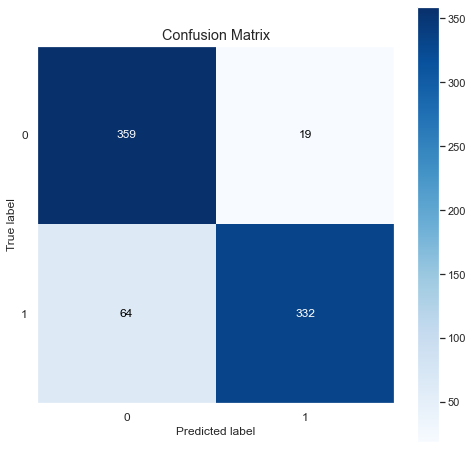

In [119]:
mt.plot_confusion_matrix(y_test, yhat_svm_tuned, normalize = False, figsize = (8,8))

# 9.0. STEP 09 - MODEL PERFORMANCE

In [120]:
X_test['Persistency_Flag'] = y_test
X_test['predictions'] = yhat_svm_tuned
X_test

,Region,Ntm_Speciality_Bucket,Dexa_Freq_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Gastro_esophageal_reflux_disease,Concom_Systemic_Corticosteroids_Plain,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Count_Of_Concomitancy,Count_Of_Comorbidity,Persistency_Flag,predictions
808,3,1,0.000,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.100,0.231,0,0
1193,1,0,0.000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.200,0.154,0,0
761,3,1,0.000,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0.500,0.077,0,0
318,1,2,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.100,0.077,0,0
2470,0,0,2.000,1,1,1,1,1,1,0,1,0,1,0,1,1,1,0,0,0.300,0.769,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,3,1,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0,0
158,3,0,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.100,0.077,0,0
1606,3,1,1.667,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0.600,0.154,1,1
331,0,1,0.000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.100,0.077,0,0


## 9.1. Business Performance

### 9.1.1. Accuracy

With the accuracy of the ML model it is possible to find out the exact number of correct predictions made by the same model.

In [121]:
df91 = pd.DataFrame({'Number_of_Values' : [X_test.shape[0]]})
df91['Accuracy'] = (result_svm_tuned['Accuracy']).astype(float64)
df91['Correct_Prediction'] = (np.round(df91['Number_of_Values'] * df91['Accuracy'])).astype(int64)

                            
df91

,Number_of_Values,Accuracy,Correct_Prediction
0,774,0.893,691


From **774** values, the ML model was able to correctly predict **691** values of the attribute 'Persistency_Flag'.

### 9.1.2. Confusion Matrix & Classification Report

With the Confusion Matrix it is possible to verify how many values of the attribute 'Persistency_Flag' were correctly and erroneously classified in each class, in other words, how many values equal to Persistent (1) and equal to Non-Presistent (0) were correctly classified, and how many of each class were not.

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       378
           1       0.95      0.84      0.89       396

    accuracy                           0.89       774
   macro avg       0.90      0.89      0.89       774
weighted avg       0.90      0.89      0.89       774



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

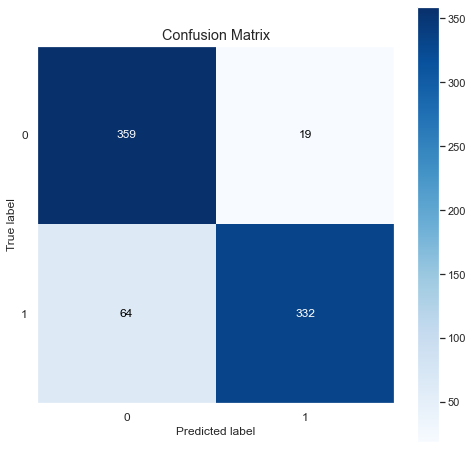

In [122]:
print(classification_report(y_test, yhat_svm_tuned))

mt.plot_confusion_matrix(y_test, yhat_svm_tuned, normalize = False, figsize = (8,8))

According to the classification_report and the consfusion matrix:

**359** values that are originally class Non-Persistent (0) have been correctly classified as Non-Persistent, which represents **95%** of the Non-Persistent class;

**332** values that are originally class Persistent (1) have been correctly classified as Persistent, which represents **83%** of the Persistent class;

**22** values that are originally class Non-Persistent (0) have been incorrectly classified as Persistent;

**64** values that are originally class Persistent (1) have been erroneously classified as Non-Persistent.

# 10.0. STEP 10 - DEPLOY MODEL TO PRODUCTION

In [123]:
# Save Training Model
pickle.dump(svm_tuned, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/model/model_classification.pkl', 'wb'))

In [124]:
# loading model
model = pickle.load(open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/model/model_classification.pkl', 'rb'))

# Class In Production

In [70]:
import pickle
import pandas as pd
import numpy as np

class Persistency(object):
    
    def __init__(self):
        self.Count_Of_Comorbidity_scaler   = pickle.load(open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Count_Of_Comorbidity_scaler.pkl', 'rb'))
        self.Count_Of_Concomitancy_scaler  = pickle.load(open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Count_Of_Concomitancy_scaler.pkl', 'rb'))
        self.Dexa_Freq_During_Rx_scaler    = pickle.load(open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Dexa_Freq_During_Rx_scaler.pkl', 'rb'))
        self.Ntm_Speciality_Bucket_scaler  = pickle.load(open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Ntm_Speciality_Bucket_scaler.pkl', 'rb')) 
        self.Region_scaler                 = pickle.load(open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Region_scaler.pkl', 'rb'))
        
    
    def data_preparation(self, df5):
        
        # 5.0. STEP 05 - DATA PREPARATION

        ## 5.2. Rescaling

        # Dexa_Freq_During_Rx uses Robust Scaler
        df5['Dexa_Freq_During_Rx'] = self.Dexa_Freq_During_Rx_scaler.fit_transform(df5[['Dexa_Freq_During_Rx']].values)  

        # Count_Of_Concomitancy uses Min-Max Scaler
        df5['Count_Of_Concomitancy'] = self.Count_Of_Concomitancy_scaler.fit_transform(df5[['Count_Of_Concomitancy']].values)
        
        # Count_Of_Comorbidity uses Min-Max Scaler
        df5['Count_Of_Comorbidity'] = self.Count_Of_Comorbidity_scaler.fit_transform(df5[['Count_Of_Comorbidity']].values)
            
        ## 5.3. TRansformation

        ### 5.3.1. Encoding

        # Categorical Variables

        # Categorical attributes that presents binary values as 'Y' and 'N', the method Label Encoding will be used in order to
        # transfoer 'Y' and 'N' values into 1 and 0 respectively.

        df5 = df5.replace('Y', 1).replace('N', 0)

        # Categorical attributes that do not presents order or scale or idea os state, each value is independent, 
        # will be use the method  Label Encoding

        # Region
        df5['Region'] = self.Region_scaler.fit_transform(df5['Region'])

        # Ntm_Speciality_Bucket
        df5['Ntm_Speciality_Bucket'] = self.Ntm_Speciality_Bucket_scaler.fit_transform(df5['Ntm_Speciality_Bucket'])

        # Categorical attributes that presents a huge amount of values, will be use the method  Target Encoding

        return df5

# Handler

In [ ]:
import pandas as pd
import pickle
from flask import Flask, request

from persistency.Persistency import Persistency

# load model
model = pickle.load(open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/model/model_classification.pkl', 'rb'))

# instanciate flask
app = Flask( __name__ )

@app.route( '/predict', methods=['POST'] )  
def predict():
    test_json = request.get_json()

    # collect data
    if test_json:
        if isinstance( test_json, dict ): # unique value
            df_raw = pd.DataFrame( test_json, index=[0] )
        else:
            df_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

    # instanciate data preparation
    pipeline = Persistency()

    # data preparation
    df1 = pipeline.data_preparation( df_raw )

    # prediction
    pred = model.predict( df1 )

    # response 
    df_raw['prediction'] = pred

    return df_raw.to_json( orient='records' )

if __name__ == '__main__':
    # star flask 
    app.run( host='127.0.0.1', port='5000' )

# Deploy API

In [339]:
teste = X_test.drop( ['Persistency_Flag','predictions'], axis=1 )

In [256]:
df_json = teste.to_json( orient='records' )

In [257]:
url = 'http://127.0.0.1:5000/predict'
#url = 'https://wine-quality-model.herokuapp.com/predict'
data = df_json
header = {'Content-type': 'application/json'}

# Request
r = requests.post( url=url, data=data, headers=header )
print( r.status_code )

200


In [271]:
x = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [329]:
d[(d['Region'] == 'South') & (d['Ntm_Speciality_Bucket'] == 'OB/GYN/Others/PCP/Unknown') & (d['Count_Of_Concomitancy'] == 1)]

,Region,Ntm_Speciality_Bucket,Dexa_Freq_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Gastro_esophageal_reflux_disease,Concom_Systemic_Corticosteroids_Plain,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Count_Of_Concomitancy,Count_Of_Comorbidity,Persistency_Flag
154,South,OB/GYN/Others/PCP/Unknown,0,N,Y,N,Y,Y,N,N,Y,Y,N,N,N,N,N,N,N,1,5,Non-Persistent
156,South,OB/GYN/Others/PCP/Unknown,0,N,N,Y,N,N,N,Y,N,N,N,N,N,N,N,N,N,1,3,Persistent
160,South,OB/GYN/Others/PCP/Unknown,0,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,1,1,Non-Persistent
170,South,OB/GYN/Others/PCP/Unknown,0,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,1,0,Non-Persistent
211,South,OB/GYN/Others/PCP/Unknown,0,Y,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1,3,Non-Persistent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3323,South,OB/GYN/Others/PCP/Unknown,0,N,Y,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,1,6,Non-Persistent
3376,South,OB/GYN/Others/PCP/Unknown,0,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,1,1,Non-Persistent
3396,South,OB/GYN/Others/PCP/Unknown,10,Y,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,1,5,Persistent
3409,South,OB/GYN/Others/PCP/Unknown,0,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,1,1,Persistent


In [339]:
x

,Region,Ntm_Speciality_Bucket,Dexa_Freq_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Gastro_esophageal_reflux_disease,Concom_Systemic_Corticosteroids_Plain,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Count_Of_Concomitancy,Count_Of_Comorbidity,prediction
0,3,1,0.000,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.100,0.250,0
1,1,0,0.000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.200,0.167,0
2,3,1,0.000,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0.500,0.083,0
3,1,2,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.100,0.083,0
4,0,0,1.200,1,1,1,1,1,1,0,1,0,1,0,1,1,1,0,0,0.300,0.833,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,3,1,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0
770,3,0,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.100,0.083,0
771,3,1,1.000,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0.600,0.167,1
772,0,1,0.000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.100,0.083,0


# Streamlit

## Rescaling for Deployment at Streamlit

## Class In Production for Streamlit

In [ ]:
import pickle
import pandas as pd
import numpy as np

class Persistency(object):
    
    def __init__(self):
        self.Count_Of_Comorbidity   = pickle.load(open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Count_Of_Comorbidity.pkl', 'rb'))
        self.Count_Of_Concomitancy  = pickle.load(open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Count_Of_Concomitancy.pkl', 'rb'))
        self.Dexa_Freq_During_Rx    = pickle.load(open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Dexa_Freq_During_Rx.pkl', 'rb'))
        
    
    def data_preparation(self, Dexa_Freq_During_Rx, Count_Of_Concomitancy, Count_Of_Comorbidity):
        
        # 5.0. STEP 05 - DATA PREPARATION

        ## 5.2. Rescaling

        # Dexa_Freq_During_Rx uses Robust Scaler
        Dexa_Freq_During_Rx = self.Dexa_Freq_During_Rx.robust_scale(Dexa_Freq_During_Rx)  

        # Count_Of_Concomitancy uses Min-Max Scaler
        Count_Of_Concomitancy = self.Count_Of_Concomitancy.robust_scale(Count_Of_Concomitancy)
        
        # Count_Of_Comorbidity uses Min-Max Scaler
        Count_Of_Comorbidity = self.Count_Of_Comorbidity.robust_scale(Count_Of_Comorbidity)

        return Dexa_Freq_During_Rx, Count_Of_Concomitancy, Count_Of_Comorbidity

In [463]:
# Dexa_Freq_During_Rx uses Robust Scaler
X_test1['Dexa_Freq_During_Rx'] = (rs.inverse_transform(X_test1[['Dexa_Freq_During_Rx']]).astype(int64))

# Count_Of_Concomitancy uses Min-Max Scaler
X_test1['Count_Of_Concomitancy'] = (mms.inverse_transform(X_test1[['Count_Of_Concomitancy']]).astype(int64))

# Count_Of_Comorbidity uses Min-Max Scaler
X_test1['Count_Of_Comorbidity'] = (mms.inverse_transform(X_test1[['Count_Of_Comorbidity']]).astype(int64))

In [337]:
# Dexa_Freq_During_Rx uses Robust Scaler
Dexa_Freq_During_Rx = robust_scale(df4['Dexa_Freq_During_Rx'])
pickle.dump(robust_scale, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Dexa_Freq_During_Rx.pkl', 'wb'))

# Count_Of_Concomitancy uses Min-Max Scaler
Count_Of_Concomitancy = minmax_scale(df5['Count_Of_Concomitancy'])
pickle.dump(minmax_scale, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Count_Of_Concomitancy.pkl', 'wb'))

# Count_Of_Comorbidity uses Min-Max Scaler
Count_Of_Comorbidity = minmax_scale(df5['Count_Of_Comorbidity'])
pickle.dump(minmax_scale, open('/Users/Igor/repos/data_glacier/final_project/deploy_streamlit/parameter/Count_Of_Comorbidity.pkl', 'wb'))